Notes 3/28/24
- Add 'inplace' (or other, maybe 'update') keyword for whether operations get applied in place... alternative: return just the variables, or a whole new object? Be consistent.
- Do I want to always return an SF object? That will make it easy to chain commands.
    - inplace option will help avoid memory issues

Notes 4/3/24

Okay! I got two basic psf-storing functions (for plotting a visualization of the psf, and for making a scene) working! I haven't tested them yet for psfs that take both r and theta as an input, and I need to do that.I have also given no thought to positional shifts on the detector, and will also need to do that. But progress!

To do:
 - incorporate theta dependence
 - test all psf functions for theta dependence
 - streamline how sigma clipping works
 - add helper functions to produce the ln(flux) data arrays
 - think about how to do position shifts on the detector
 - Try adding in an extra component to the design matrix that only kicks in for bright targets

Notes 4/29/24

* Three nterms in the theta dependence is the minimum!
* pull new la matrix
* incorporate gradient shifts

Notes 5/3/24

Goal for pre-commissioning:
- Test FFI cutouts of different sizes. Do the PSF fitting on them, then take the chi-sq of the (data-model). Creat of plot of # of sources vs. chi-sq to get a sense of how big of an image we need from commissioning.
- Do by early next week?

Notes 5/9/24

I have redone the initial fitting step of the psf to skip the iterative grid search and use do_initial_fit() to get the first round of 2D gaussian fits, flux coeff, and xy shifts.

There are still asome things to square away:
* Standardize 'dx' and 'dy' throughout the sf object
* Do some sanity checks for the flux coeffs we're getting
* Explore the effects of sigma clipping on the initial fit
* Explore the effects of only fitting the core on the initial fit
* Standardize function returns and 'update' keywords
* Clean up the class variables (need to make sure everything is using stddev_x and _y properly)
* Keep cleaning up this notebook.

...and make chi-squared plot for Christina!!

Notes 5/10/24

Things to do when I get back on Monday:
* Appying the shifts in _convert_to_radial_coordinates() is not working and I'm not sure why. Take another look.
* make a plot of r vs. z that is colored by contamination ratio

Sigma clipping thoughts:
* Probably best to fit a spline to the central points of the r vs. z curve
* Have outlier_mask be a separate class variable that gets passed like la.fit(mask=outlier_mask)
* Think about when it makes sense to do calls for making the outlier mask
* make supplementary plotting function to easily check outlier clipping?


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
from copy import deepcopy
from functools import lru_cache

import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord, match_coordinates_sky
from astropy.time import Time
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from scipy import sparse
from tqdm import tqdm
from astropy.io import fits

In [4]:
import sys
import imp
sys.path.insert(0, '../')
import utils
from utils import SparseWarp3D

from scene_fitter import SceneFitter
import scene_fitter
import lamatrix as la
from IPython import display

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_55623/4249387505.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [5]:
# for now, just use get_wcs_and_catalog(). Fix the other ones later

def get_wcs_and_catalog(hdulist, cutout):
    """Queries a catalog for a cut out of a tess file. Currently configured for TESS cutouts. Cutout format is [[row_min, row_max], [col_min, col_max]]"""
    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()
    shape = R.shape

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    radius = np.max(c.separation(cs).deg)

    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # I bet this "round" step is the culprit for why the weights look weird later
    # instead, we should keep a rounded and an unrounded version
    df[["Y", "X"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["Y0", "X0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - shape[0]/2 - 3)
        & (df.X0 < R0 + shape[0]/2 + 3)
        & (df.Y0 > C0 - shape[1]/2 - 3)
        & (df.Y0 < C0 + shape[1]/2 + 3)
    )
    print(sum(k))
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)
    catalog = df

    return wcs, catalog

def get_cutout_and_catalog(hdulist, cutout):
    """Queries a catalog for a cut out of a tess file. Currently configured for TESS cutouts. Cutout format is [[row_min, row_max], [col_min, col_max]]"""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    radius = np.max(c.separation(cs).deg)

    # # update header values
    # for i in [1,2]:
        # output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        # output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        # output[i].header['CRPIX1'] = R0
        # output[i].header['CRPIX2'] = C0
        # output[i].header['CRVAL1'] = ra0
        # output[i].header['CRVAL2'] = dec0
    
    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # I bet this "round" step is the culprit for why the weights look weird later
    # instead, we should keep a rounded and an unrounded version
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
        & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
        & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
        & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    )
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return output, wcs, df

def clip_TESS_fits(hdulist, cutout):
    """Clip a TESS hdu to a smaller one. Returns the WCS built from the original TESS file, since building one based off the clipped file seems to cause problems."""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(C0, R0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    # update header values
    for i in [1,2]:
        output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        # output[i].header['CRPIX1'] = R0
        # output[i].header['CRPIX2'] = C0
        # output[i].header['CRVAL1'] = ra0
        # output[i].header['CRVAL2'] = dec0

    return output, wcs, R, C

def get_catalog(hdulist, wcs, R, C):
    """Queries a catalog for a given hdu. Currently configured for TESS cutouts."""
    # wcs = WCS(hdulist[1].header)
    R0 = hdulist[1].header['CRPIX1']
    C0 = hdulist[1].header['CRPIX2']
    # cutout = [[R0 - hdulist[1].header['NAXIS1']/2, 
    #            R0 + hdulist[1].header['NAXIS1']/2],
    #           [C0 - hdulist[1].header['NAXIS2']/2,
    #            C0 + hdulist[1].header['NAXIS2']/2]]
    
    
    # R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    c = wcs.pixel_to_world(C0, R0)
    cs = wcs.pixel_to_world(C[l[0], l[1]], R[l[0], l[1]])
    # cs = wcs.pixel_to_world(R0 - hdulist[1].header['NAXIS1']/2, 
    #                         C0 - hdulist[1].header['NAXIS2']/2)
    ra0, dec0 = c.ra.deg, c.dec.deg    
    # ra0 = hdulist[1].header['CRVAL1']
    # dec0 = hdulist[1].header['CRVAL2']
    radius = np.max(c.separation(cs).deg)

    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # format the catalog
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # this looks like it's taking a 3 pixel buffer around the image
    k = (
        (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
        & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
        & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
        & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    )
    df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return df


In [6]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py'>

In [7]:
# NEW open tess cutout
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "../../../data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
)
# cutout = [[1500,1700], [1501,1700]]
# cutout = [[1500,1700], [1451,1700]]
cutout = [[500,700], [1451,1700]]

# hdu1, wcs, R, C = clip_TESS_fits(hdulist, cutout)
# df = get_catalog(hdu1, wcs, R, C)
# hdu1, wcs, df = get_cutout_and_catalog(hdulist, cutout)

# I think I like this format most
wcs, df = get_wcs_and_catalog(hdulist, cutout)


Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]
2855


In [186]:
imp.reload(scene_fitter)
from scene_fitter import SceneFitter
# sf = SceneFitter(hdulist, df, cutout=cutout)
sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs)

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:273: RuntimeWarning: invalid value encountered in log
  # get dx, dy, r, and phi


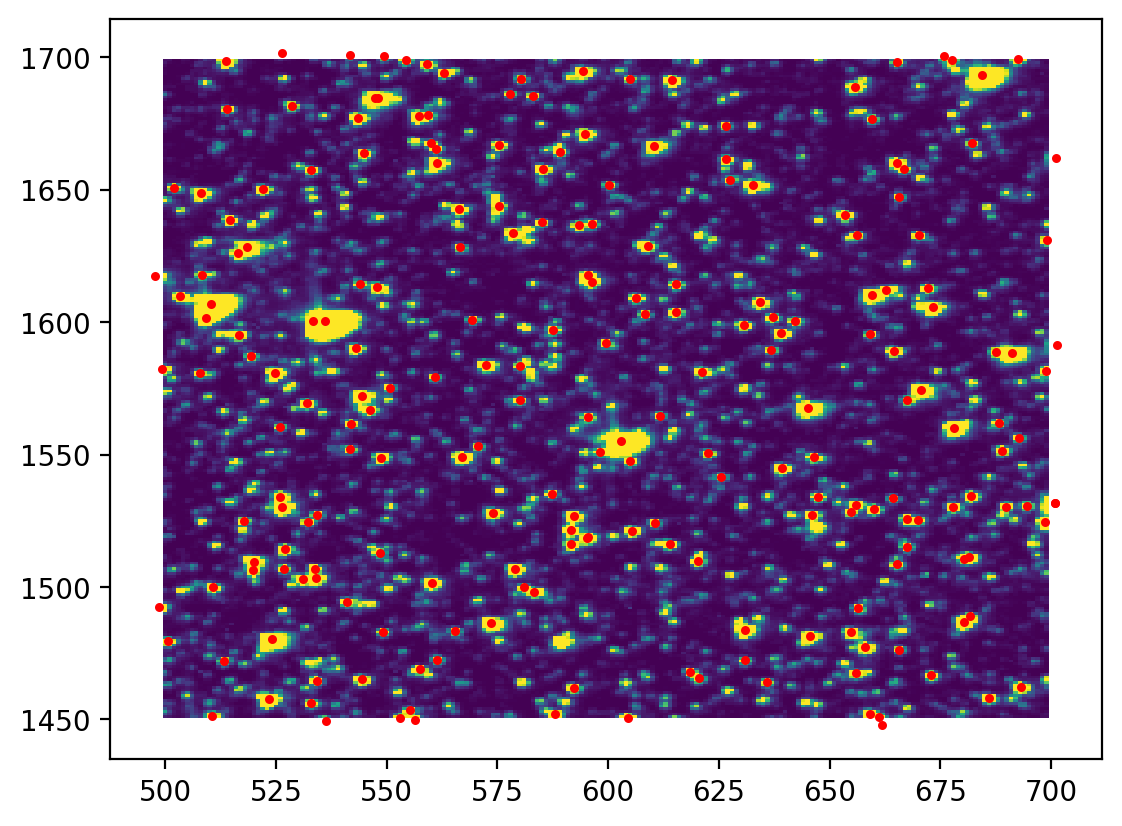

In [281]:
# plt.imshow(sf.data, vmin=0, vmax=200)
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
plt.pcolormesh(R, C, sf.data, vmin=0, vmax=200)
bright_sources = sf.df.phot_rp_mean_flux > 1e5

# corner_y = hdu1[1].header['CRPIX2'] - hdu1[1].header['NAXIS2']/2
# corner_x = hdu1[1].header['CRPIX1'] - hdu1[1].header['NAXIS1']/2

# plt.scatter(df["X0"][bright_sources] - corner_x, df["Y0"][bright_sources] - corner_y, s=5, c="r")
plt.scatter(sf.df["X0"][bright_sources], sf.df["Y0"][bright_sources], s=5, c="r")


New workflow
1. Assume 1 pixel std gaussian with shifts allowed.
2. Make ss_mask (happens automatically on initialization)
3. Do a fit. This will give you shifts, a new std, and a flux coeff.
4. Run update_psf() to remake the ss_mask
5. Check and see how good we're doing?
6. See if doing this step again helps more



In [482]:
# testing the new first step
imp.reload(scene_fitter)
from scene_fitter import SceneFitter

df1 = df[bright_sources]
sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs)

sf1 = sf.copy()
psf1 = sf1.do_initial_fit(update=True, second_level_fit=True)

# test and see if handling the shifts separately works okay
sf2 = sf.copy()
sf2.update_psf(psf=psf1[0])

sf3 = sf.copy()
sf3.update_psf(psf=psf1[0], xshift=sf1.xshift, yshift=sf1.yshift )

# sf2.gaia_flux_coeff = sf1.gaia_flux_coeff
# sf2.stddev_x = sf1.stddev_x
# sf2.stddev_y = sf1.stddev_y
# sf2.xshift = sf1.xshift
# sf2.yshift = sf1.yshift

print(sf.model_rmse())
print(sf1.model_rmse())
print(sf2.model_rmse())
print(sf3.model_rmse())


/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:298: RuntimeWarning: invalid value encountered in log
  
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)
/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:298: RuntimeWarning: invalid value encountered in 

477099.654484058
616.3181322753379
474.7736286959235
471.22829390112264


/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py:261: UserWarning: Warning: converting a masked element to nan.
  x_sort, y_sort = np.array(x_sort), np.array(y_sort)


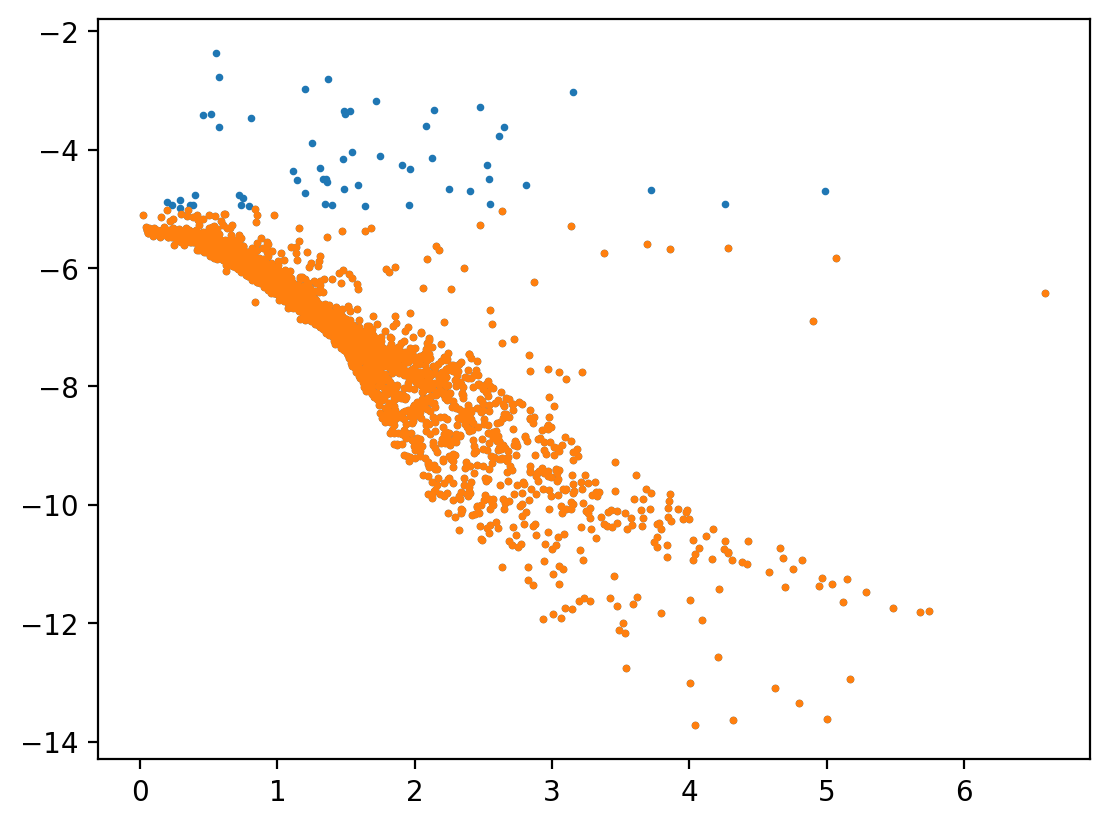

In [483]:
_, _, sigma_mask = utils.iterative_sigma_clip(sf2.r, sf2.z, cenfunc=utils.custom_fit, sigma_clip_kwargs={'sigma_upper':5, 'sigma_lower':5}, cenfunc_kwargs={'n_bin':20, 'k':4, 'fit_func':utils.func_line})

plt.scatter(sf2.r, sf2.z, s=3)
# plt.scatter(sf2.r[sigma_mask], sf2.z[sigma_mask], s=3)
plt.scatter(sf2.r[sf2.z < -5], sf2.z[sf2.z < -5], s=3)


3032 3058


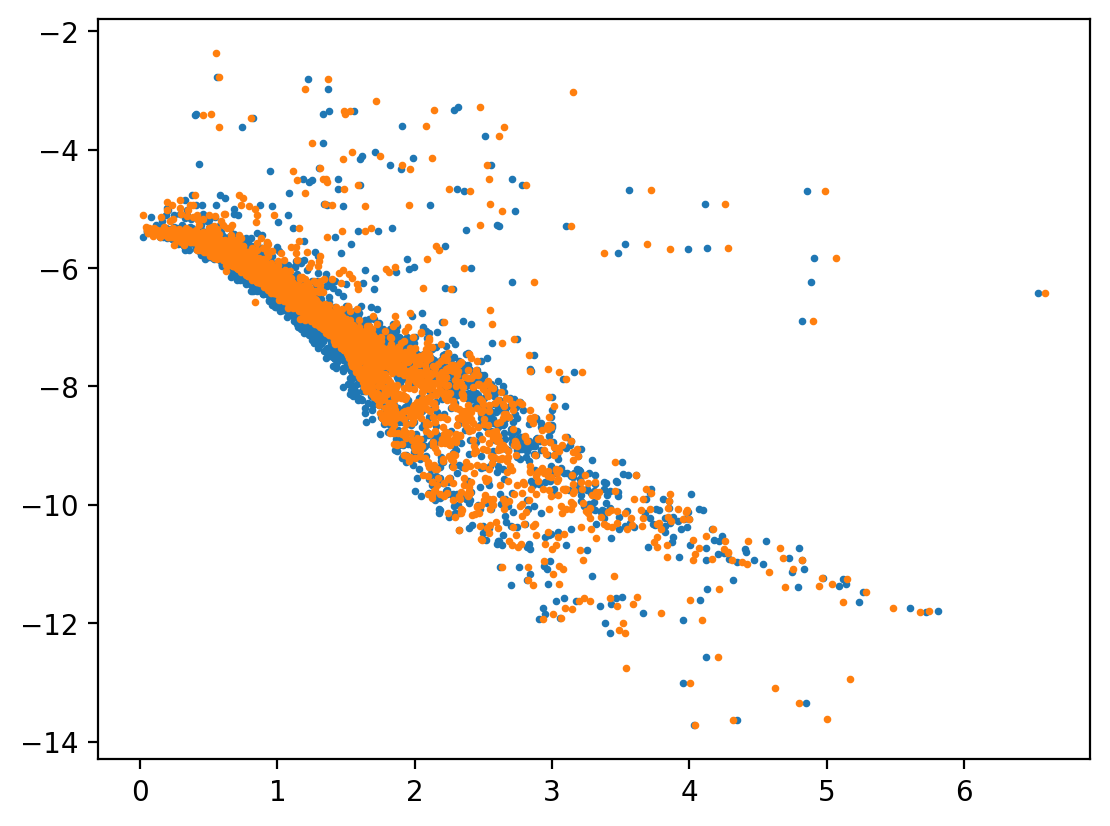

In [452]:
# compare the model images you get from applying the shifts or not

# scene1 = sf2._get_psf_scene(xshift=0, yshift=0)
# scene2 = sf2._get_psf_scene()

# mi1 = np.asarray(scene1.sum(axis=1).reshape(sf2.shape))
# mi2 = np.asarray(scene2.sum(axis=1).reshape(sf2.shape))

plt.scatter(sf3.r, sf3.z, s=3)
plt.scatter(sf2.r, sf2.z, s=3)
print(len(sf2.r), len(sf3.r))

# plt.imshow((sf2.data - sf3.model_image), vmin=-200, vmax=200)
# plt.colorbar()
# plt.show()

# plt.imshow((sf2.data - sf2.model_image), vmin=-200, vmax=200)
# plt.colorbar()
# plt.show()


In [343]:
# I want to check and see if the gradient component changes the total flux injected into the model image
sf1 = sf.copy()
sf2 = sf.copy()

sf1.update_psf(psf1)
sf2.update_psf(psf1[0])

print(np.sum(sf1.model_image))
print(np.sum(sf2.model_image))


/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:273: RuntimeWarning: invalid value encountered in log
  # get dx, dy, r, and phi


7167592.607467573
7077656.020803824


In [352]:
g1 = psf1[0]
dg1 = psf1[1]
print(g1.stddev_y)
print(dg1.stddev_y)


(1.0673890154364176, 0.00018239164674059024)
1.1254534619902747


In [323]:
# print(np.exp(sf1.psf[0].mu[0]))
# print(sf1.gaia_flux_coeff)
sf1.psf[0]

lnGaussian2DGenerator(x, y)[n, 4] fit

In [381]:
# we should set priors that the shifts shouldn't be more than a pixel
# set up 2d gaussian with a set stddev
std = 1.
g1 = la.lnGaussian2DGenerator('x', 'y', stddev_x_prior=(std, 1), stddev_y_prior=(std, 1))
g1.fit(x=sf.dx, y=sf.dy, data=sf.z, errors=sf.zerr)#, mask=data_mask)

# now add in the gradient and fit
dg1 = g1.gradient
dg1.prior_sigma = np.array([np.inf, 1, 1])
model = g1 + dg1
model.fit(x=sf.dx, y=sf.dy, data=sf.z, errors=sf.zerr)#, 

# doing the fit with the gradient will change the std of g1 so that the std of g1 and dg1 won't match anymore
# let's do one more fit to see if we can improve that
# model[0].update_priors()

print(model[1].fit_mu)
print(model[1].prior_sigma)


[-0.          0.04155177 -0.1809113 ]
[inf  1.  1.]


In [382]:
g2 = model[0].copy()
g2.update_priors()

dg2 = g2.gradient
dg2.prior_sigma = np.array([np.inf, 1, 1])
model2 = g2 + dg2
model2.fit(x=sf.dx, y=sf.dy, data=sf.z, errors=sf.zerr)

print(model[0].fit_mu)
print(model2[0].fit_mu)


[-5.83849923 -0.45856744 -0.43904224 -0.01835661]
[-5.83849923 -0.45856744 -0.43904224 -0.01835661]


In [390]:
print(model[1].shift_x)
print(model2[1].shift_x)

print(model[1].shift_y)
print(model2[1].shift_y)

print(model[1].stddev_x)
print(model2[1].stddev_x)

print(model[0].stddev_y)
print(model2[0].stddev_y)

sf1 = sf.copy()
sf2 = sf.copy()

sf1.update_psf(model)
sf2.update_psf(model2)

print(sf1.model_rmse())
print(sf2.model_rmse())

(0.0415517661847492, 0.00035715119514535945)
(0.04371731860085495, 0.0003402564346349895)
(-0.1809112959595097, 0.0003478793300630973)
(-0.16309729563024983, 0.0002928414175800343)
1.0503611424021244
1.0444178229099756
(1.0673890154364176, 0.00018239164674059024)
(1.0673890152407972, 0.00012403276936154704)


/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:273: RuntimeWarning: invalid value encountered in log
  # get dx, dy, r, and phi


480.83724140197637
480.83724246135694


In [366]:
print(g1.prior_mu, g1.fit_mu, )
print(model[0].prior_mu, model[0].fit_mu)
model[0].update_priors()
# print(g1.prior_mu)
print(g1.prior_mu, g1.fit_mu, )
print(model[0].prior_mu, model[0].fit_mu)


[ 0.  -0.5 -0.5  0. ] [-5.8661108  -0.45377722 -0.39524365 -0.03013206]
[ 0.  -0.5 -0.5  0. ] [-5.83849923 -0.45856744 -0.43904224 -0.01835661]
[ 0.  -0.5 -0.5  0. ] [-5.8661108  -0.45377722 -0.39524365 -0.03013206]
[-5.83849923 -0.45856744 -0.43904224 -0.01835661] [-5.83849923 -0.45856744 -0.43904224 -0.01835661]


In [242]:
xshift = .1; yshift = 0;
z = np.log((sf.y / sf.max_contributor_flux))
zerr = 2.5 * sf.yerr/sf.y * np.log(10)

# get dx, dy, r, and phi
dx = np.hstack(sf.R.ravel() - (sf.df.iloc[sf.max_contributor_ind]['X0'].to_numpy() + xshift))
dy = np.hstack(sf.C.ravel() - (sf.df.iloc[sf.max_contributor_ind]['Y0'].to_numpy() + yshift))
z, zerr, dx, dy, = z[sf.ss_mask], zerr[sf.ss_mask], dx[sf.ss_mask], dy[sf.ss_mask] 
r, phi = np.hypot(dx, dy), np.arctan2(dy, dx)

print(r)

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_55623/3872004802.py:2: RuntimeWarning: invalid value encountered in log
  z = np.log((sf.y / sf.max_contributor_flux))


[1.95233194 1.55293271 1.73539621 ... 1.46754898 1.11072049 3.09232922]


In [153]:
# testing the new first step
imp.reload(scene_fitter)
from scene_fitter import SceneFitter

df1 = df[bright_sources]
sf = SceneFitter(hdulist, df1, cutout=cutout, wcs=wcs)

def do_initial_fit(self, std=None, source_flux=None, update=False):
    if std is None:
            std = self.initial_std
    if source_flux is None:
        source_flux = self.gaia_flux

    # set up 2d gaussian with a set stddev
    g1 = la.lnGaussian2DGenerator('x', 'y', stddev_x_prior=(std, 1), stddev_y_prior=(std, 1))
    g1.fit(x=self.dx, y=self.dy, data=self.z, errors=self.zerr)#, mask=data_mask)

    # now add in the gradient and fit
    dg1 = g1.gradient
    model = g1 + dg1
    model.fit(x=self.dx, y=self.dy, data=self.z, errors=self.zerr)#, mask=data_mask)

    if update:
        self.update_pself(model)
        self.gaia_flux_coeff = np.exp(model.mu[0])
        self.stddev_x = model[0].stddev_x
        self.stddev_y = model[0].stddev_y
        _, self.xshift, self.yshift = model[1].fit_mu
         
    # return the psf
    return model

model = do_initial_fit(sf)

# extract variables of interest


/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../scene_fitter.py:270: RuntimeWarning: invalid value encountered in log
  z = np.log((self.y / self.max_contributor_flux))
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


In [155]:
print(sf.gaia_flux_coeff, sf1.gaia_flux_coeff)
# flux_coeff

# sf.update_psf(model)
sf.gaia_flux_coeff = np.exp(model.mu[0])
sf.stddev_x = model[0].stddev_x
sf.stddev_y = model[0].stddev_y
_, sf.xshift, sf.yshift = model[1].fit_mu

1.0 1.0


In [129]:
stds = np.arange(1, 1.5, 0.1)
ind = 3
model = psfs[ind]
print(np.exp(model.mu[0]))
print(model.mu[-2], model.mu[-1])
print(stds[ind])

print(model[0].stddev_x)
print(model[0].stddev_y)
print(model[1].fit_mu)
print(np.exp(model.mu[0]))

flux_coeff = np.exp(model.mu[0])
stddev_x = model[0].stddev_x
stddev_y = model[0].stddev_y
_, xshift, yshift = model[1].fit_mu


0.001710826737469153
-0.44560756666928775 -0.09901748416602939
1.3000000000000003
(1.7622331442253507, 0.00015619392780883928)
(1.6676768877055899, 0.00015311710703224554)
[-0.         -0.44560757 -0.09901748]
0.001710826737469153


In [92]:
# NEW quick testing
imp.reload(utils)
imp.reload(scene_fitter)
from scene_fitter import SceneFitter
sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs,
                gaia_flux_coeff=gaia_flux_coeff,  # 0.015366
                initial_std=initial_std,)   # 1.1

# set the initial psf to be a gaussian with std=1
# g0 = la.lnGaussian1DGenerator('r', stddev_prior=(1, 1))
# sf.update_psf(g0)

# get radial coordinates from initial psf
r, th, z, zerr, dx, dy = sf._convert_to_radial_coordinates()

# sigma clip those and apply the masks
# perhaps later, streamline by combining with the above step
_, _, sigma_mask = utils.iterative_sigma_clip(r, z, cenfunc=utils.custom_fit, sigma_clip_kwargs={'sigma_upper':5, 'sigma_lower':5}, cenfunc_kwargs={'n_bin':20, 'k':4, 'fit_func':utils.func_line})

# fig = sf.plot_radial_data(sigma_mask=sigma_mask)
# fig = sf.plot_radial_psf()

# plt.imshow(sf.model_image - sf.data, vmin=0, vmax=200)
# plt.imshow(sf.data, vmin=0, vmax=200)
# plt.colorbar()



/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py:261: UserWarning: Warning: converting a masked element to nan.
  x_sort, y_sort = np.array(x_sort), np.array(y_sort)


0.0018364172888559668


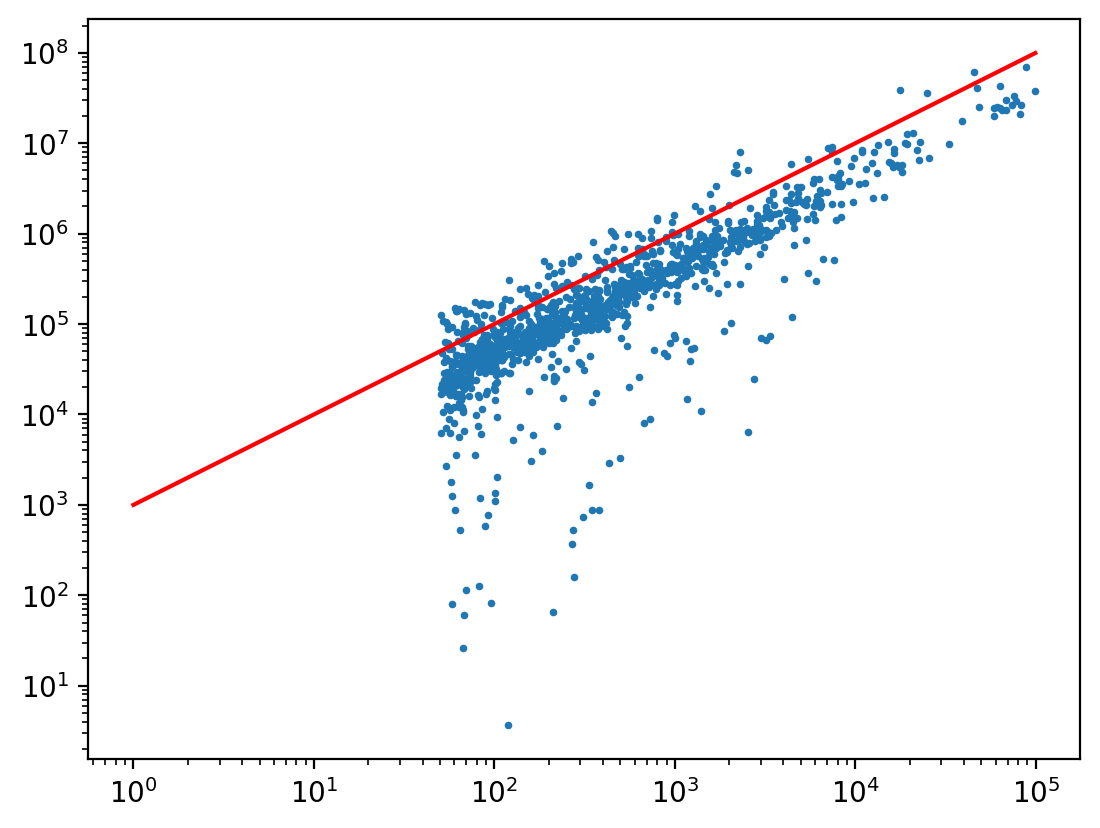

In [218]:
# plt.imshow(mi2 / sf.data, vmin=-100, vmax )
# plt.colorbar()
# plt.show()

mask1 = sf.y > 1
mask1 = sf.ss_mask
# plt.errorbar(sf.y, mi2.ravel()/sf.data.ravel(), sf.yerr, linestyle='')
# plt.scatter(sf.y[mask1], (mi2.ravel()/sf.data.ravel())[mask1])
# plt.ylim([-100,1000])
# plt.xlim([0,10])

arr1 = np.linspace(1, max(sf.y), 10)
arr2 = 1000 * arr1

plt.scatter(sf.y[mask1], (mi2.ravel())[mask1], s=3)
plt.plot(arr1, arr2, c='r')
plt.xscale('log')
plt.yscale('log')

print(1/np.mean((mi2.ravel()/sf.data.ravel())[mask1]))

In [230]:
# sf.df.phot_g_mean_flux.values
def _fit_flux_coeff_only(sf, flux_mask_cutoff=1,):
    # get the model image using the original source flux
    scene =  sf._get_psf_scene(source_flux=sf.df.phot_g_mean_flux.values)
    mi = np.asarray(scene.sum(axis=1).reshape(sf.shape))

    # mask out pixels below a certain flux cutoff
    mask1 = sf.y > flux_mask_cutoff

    # set up the generator, a 0d polynomial

mask1 = sf.y > 10
# mask1 = sf.ss_mask
# g1 = la.Polynomial1DGenerator('flux', polyorder=1, prior_mu=(0, 1), prior_sigma=np.array([0, np.inf]))
# g1.fit(flux=mi2.ravel(), data=sf.y, errors=sf.yerr, mask=mask1)

# try it in logspace? fix the slope to be 1 and let the offset float
g1 = la.Polynomial1DGenerator('log_flux', polyorder=1, prior_mu=(0, 1), prior_sigma=np.array([np.inf, 0]))
g1.fit(log_flux=np.log10(mi2.ravel()), data=sf.z, errors=sf.zerr, mask=mask1)


print(g1.equation)
print(g1.mu)

# # recover the variables of interest
# flux_coeff = g.mu[1]
# dx, dy = g.mu[3], g.mu[5]
# rmse = np.sqrt(np.mean((sf.y - g.evaluate(flux=flux, dfdx=dfdx, dfdy=dfdy))**2))

\[f(\mathbf{log_flux}) = w_{0} \mathbf{log_flux}^{0} + w_{1} \mathbf{log_flux}^{1}\]
[nan  0.]


/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_28670/1661213653.py:19: RuntimeWarning: invalid value encountered in log10
  g1.fit(log_flux=np.log10(mi2.ravel()), data=np.log10(sf.y))#, errors=sf.zerr, mask=mask1)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: divide by zero encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


In [ ]:
def _get_psf_scene_xy(self, source_flux=None, std=None, x_col='X0', y_col='Y0', dx=0, dy=0, nstddevs=5) -> utils.SparseWarp3D:
    """Generates a scene from the current psf, assuming an input basis in xy coordinates. Currently does NOT generate gradients of the scene."""    
    if std is None:
        std = self.initial_std
    if source_flux is None:
        source_flux = self.source_flux

    xval = self.df[x_col] + dx
    yval = self.df[y_col] + dy

    # row and column grids
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]

    # for just one slice of the scene
    ggR = gR[:,:,None] - np.asarray(xval % 1)
    ggC = gC[:,:,None] - np.asarray(yval % 1)

    # rads = np.hypot(ggR, ggC)
    rads, thetas = np.hypot(ggR, ggC), np.arctan2(ggC, ggR)
    source = np.exp(self.psf.evaluate(r=rads.ravel(), theta=thetas).reshape(ggR.shape))

    scene = utils.SparseWarp3D(
                    source * source_flux,
                    gR[:, :, None] + np.asarray(np.floor(xval - self.R[0, 0])).astype(int),
                    gC[:, :, None] + np.asarray(np.floor(yval - self.C[0, 0])).astype(int),
                    self.shape,
                )
    
    return scene

In [20]:
r = r[sigma_mask]
th = th[sigma_mask]
z = z[sigma_mask]
zerr = zerr[sigma_mask]
dx = dx[sigma_mask]
dy = dy[sigma_mask]


In [22]:
sigma_mask.shape
sf.dx.shape

(12188,)

/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py:261: UserWarning: Warning: converting a masked element to nan.
  x_sort, y_sort = np.array(x_sort), np.array(y_sort)


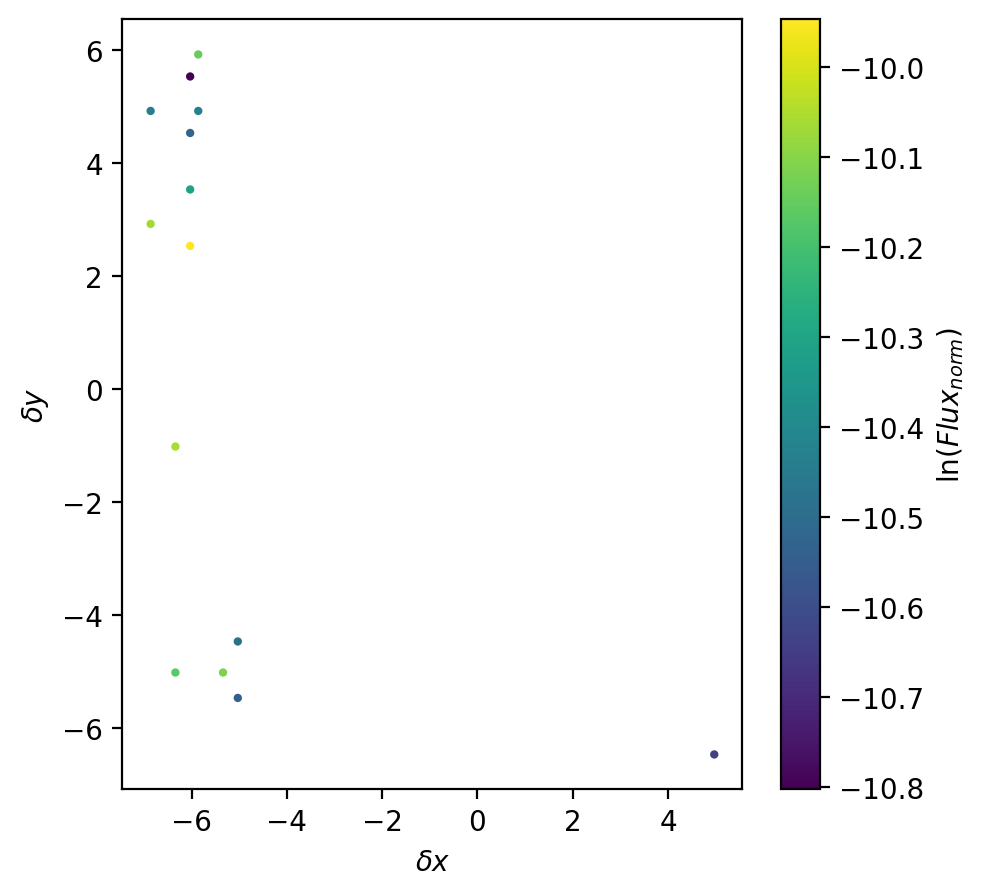

In [32]:
_, _, sigma_mask = utils.iterative_sigma_clip(sf.r, sf.z, cenfunc=utils.custom_fit, sigma_clip_kwargs={'sigma_upper':5, 'sigma_lower':5}, cenfunc_kwargs={'n_bin':20, 'k':k, 'fit_func':utils.func_line})

fig = sf.plot_radial_data(sigma_mask=~sigma_mask)

[Text(0.5, 0, '$\\delta x$'), Text(0, 0.5, '$\\delta y$')]

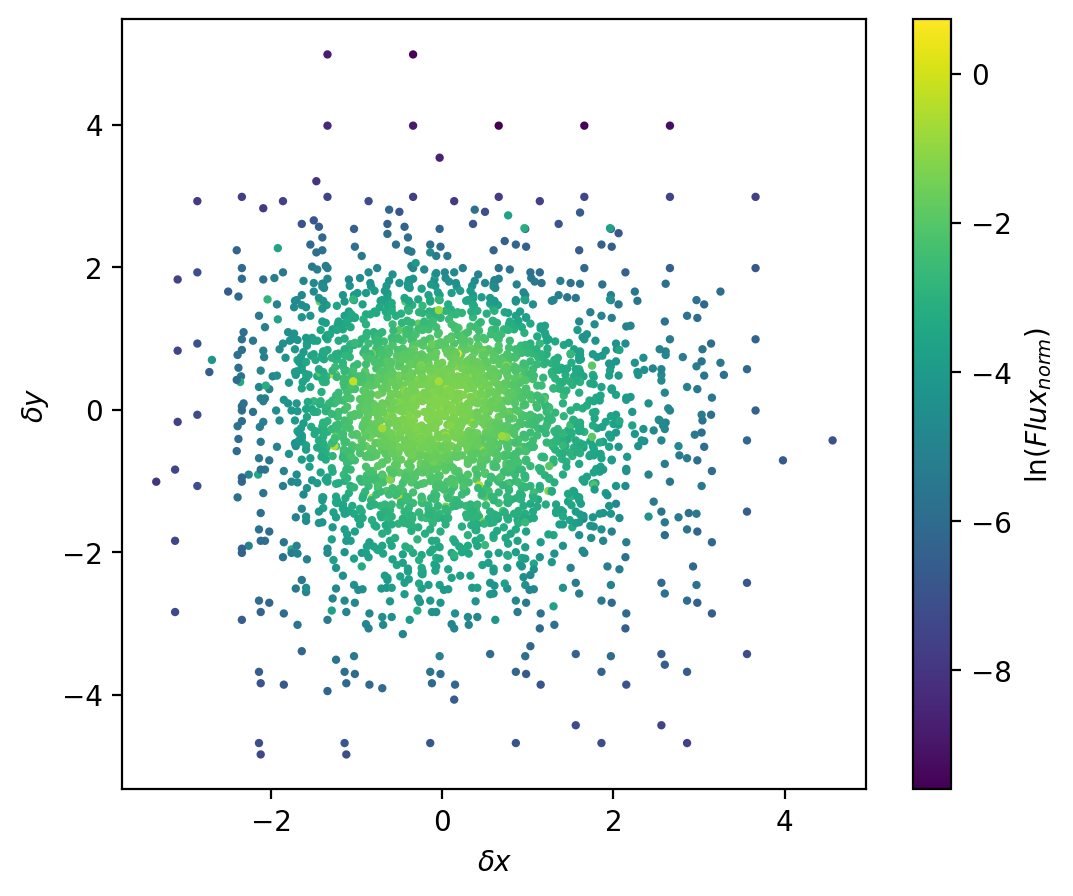

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))
#ax.errorbar(rad, y, ye, color='k', ls='', lw=0.3)
im = ax.scatter(dx, dy, c=z, s=4)
fig.colorbar(im, label='$\ln(Flux_{norm}$)')
ax.set(xlabel='$\delta x$', ylabel='$\delta y$')#, title='TESS CVZ Stars S01');

In [ ]:
# test = la.Polynomial1DGeneratorOdd
imp.reload(la)
la.models.simple.Polynomial1DGeneratorOdd

In [ ]:
# g_core = la.BoundedGenerator(g2, x_name='r', bounds=[(0, 2*g1.stddev[0])])
# g_wings = la.BoundedGenerator(g3, x_name='r', bounds=[(2*g1.stddev[0], 100)])

(63, 50)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2738 but corresponding boolean dimension is 12188

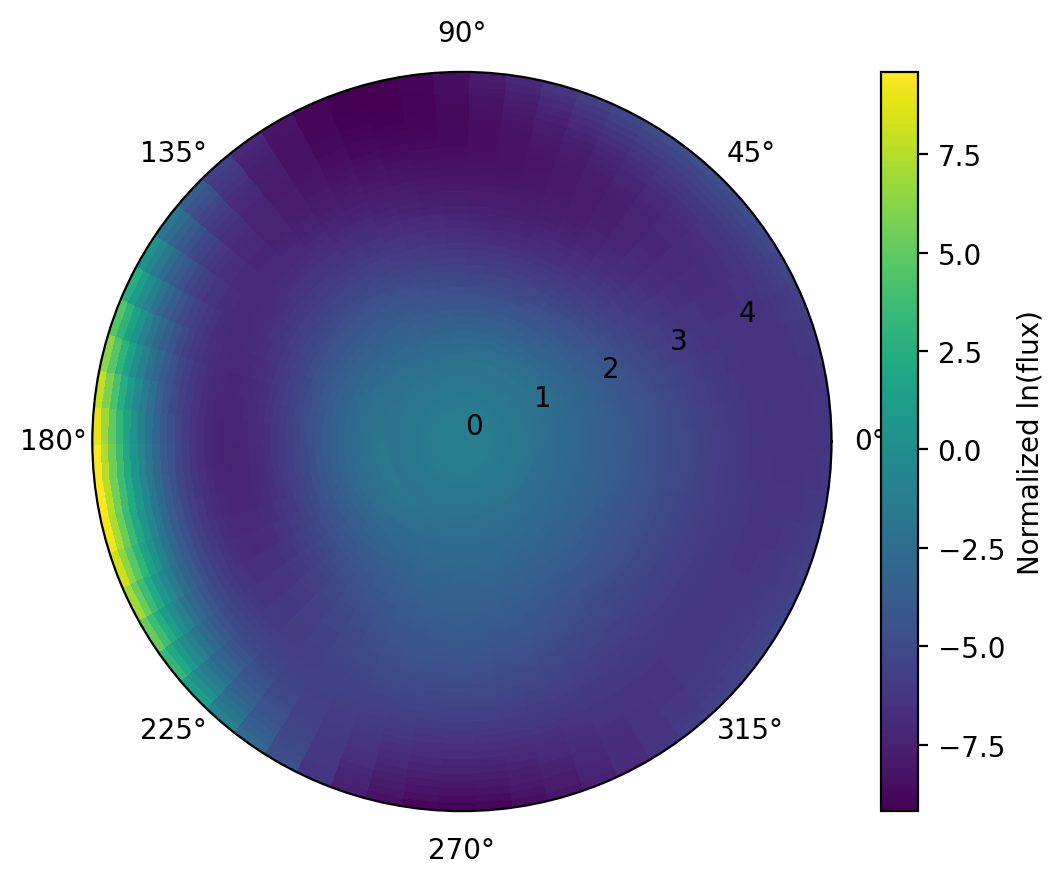

<Figure size 640x480 with 0 Axes>

In [26]:
r1 = la.models.simple.Polynomial1DGenerator(x_name='r', polyorder=3)
r1.fit(r=r, data=z, errors=zerr)
r1.update_priors()

p1 = la.BoundedGenerator(la.SinusoidGenerator('theta', nterms=3, prior_sigma=np.ones(7) * 1e4), [(1, 100)], x_name='r', fill_value=1)
psf_model = r1 * p1

psf_model.fit(r=r, theta=th, data=z, errors=zerr)#, mask=ccdmask)

sf1 = sf.copy()
sf1.psf = psf_model
fig = sf1.plot_radial_psf()

plt.figure()
model_z = psf_model.evaluate(r=r, theta=th)
# plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
plt.scatter(r[sigma_mask], z[sigma_mask], s=3)
plt.scatter(r, model_z, s=3, c='red')
plt.xlabel('Radial distance from source')
plt.ylabel('ln Flux')

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf]
(63, 50)


Text(0, 0.5, 'ln Flux')

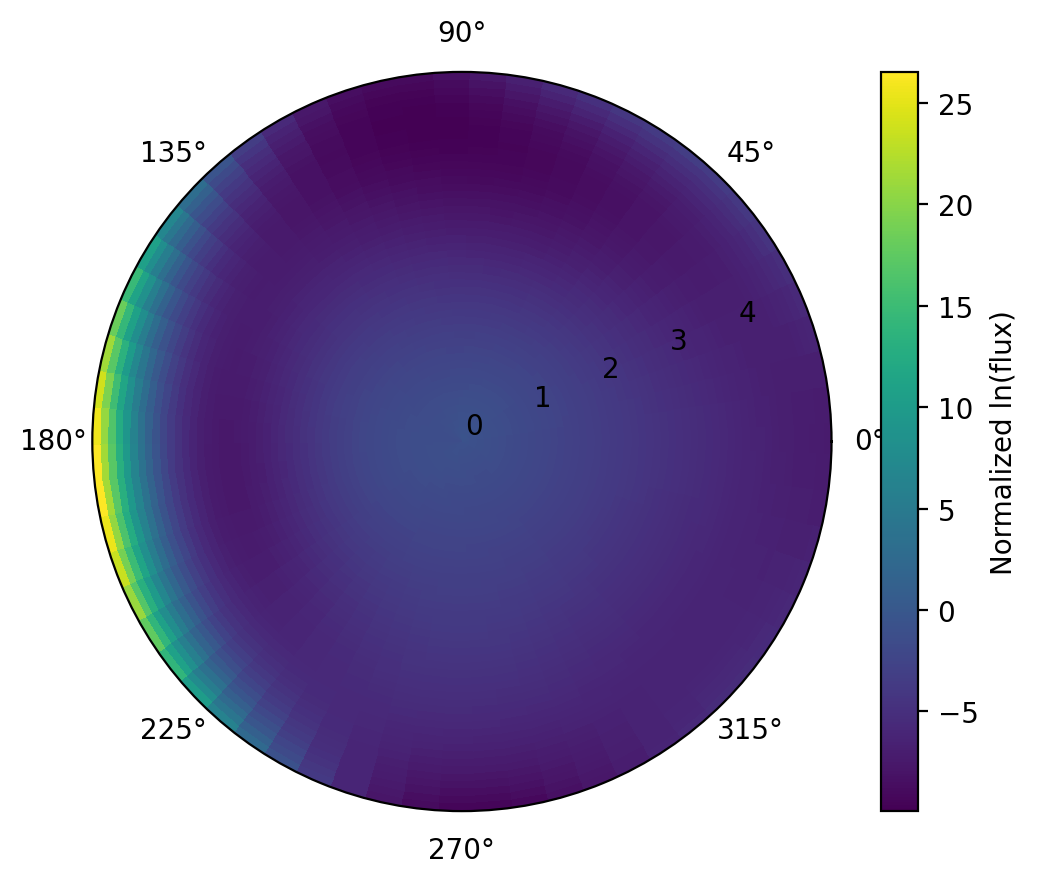

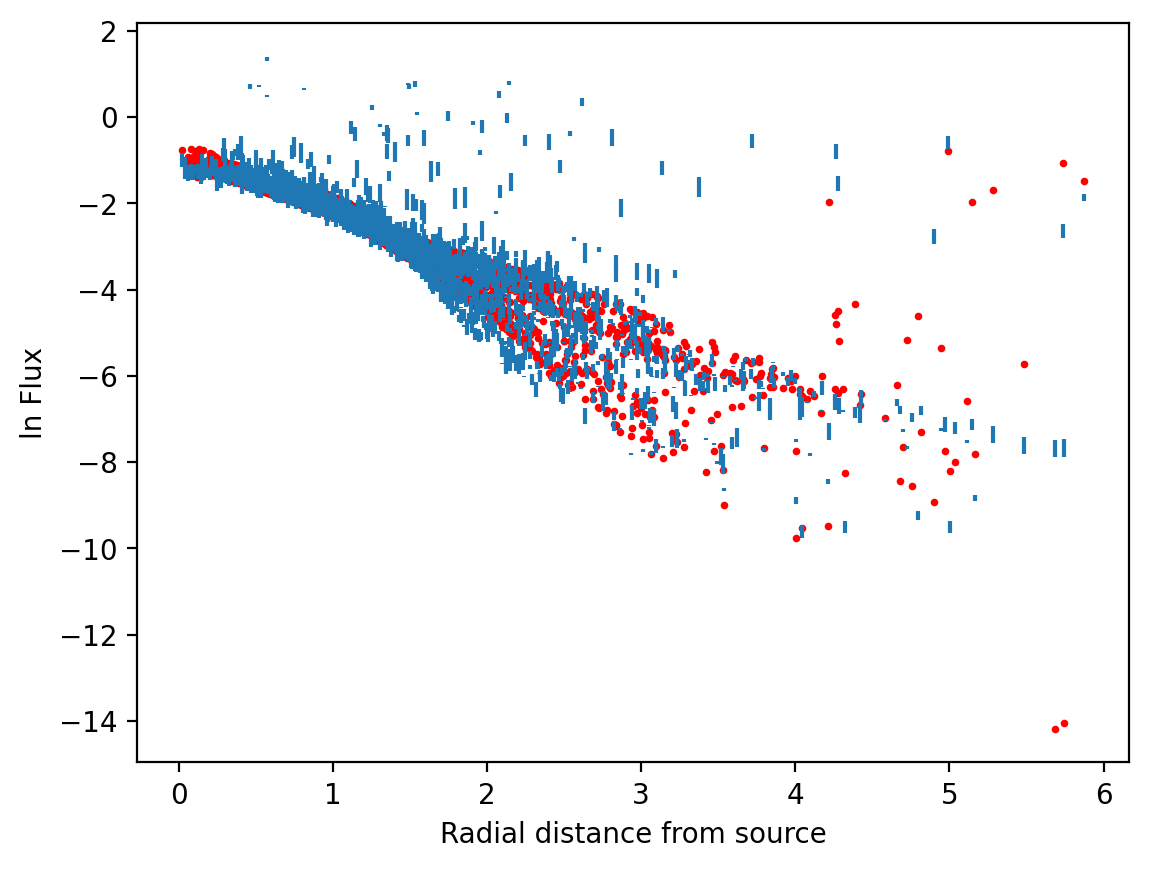

In [14]:
# gr = la.Polynomial1DGenerator(x_name='r', polyorder=3)#, 
# gr = la.Polynomial1DGenerator(x_name='r', polyorder=3)#, 
gr = la.models.simple.Polynomial1DGeneratorOdd(x_name='r', polyorder=5)#, 

# three term minimum to capture centroid offset!!
gth = la.SinusoidGenerator(x_name='theta', nterms=3)
# gth2 = la.SinusoidGenerator(x_name='theta')
blob = gr * gth

print(blob.prior_sigma)

blob.fit(r=r, theta=th, data=z, errors=zerr)

sf1 = sf.copy()
sf1.psf = blob
fig = sf1.plot_radial_psf()

# sf.update_psf(blob)

plt.figure()
model_z = blob.evaluate(r=r, theta=th)
plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
plt.scatter(r, model_z, s=3, c='red')
plt.xlabel('Radial distance from source')
plt.ylabel('ln Flux')

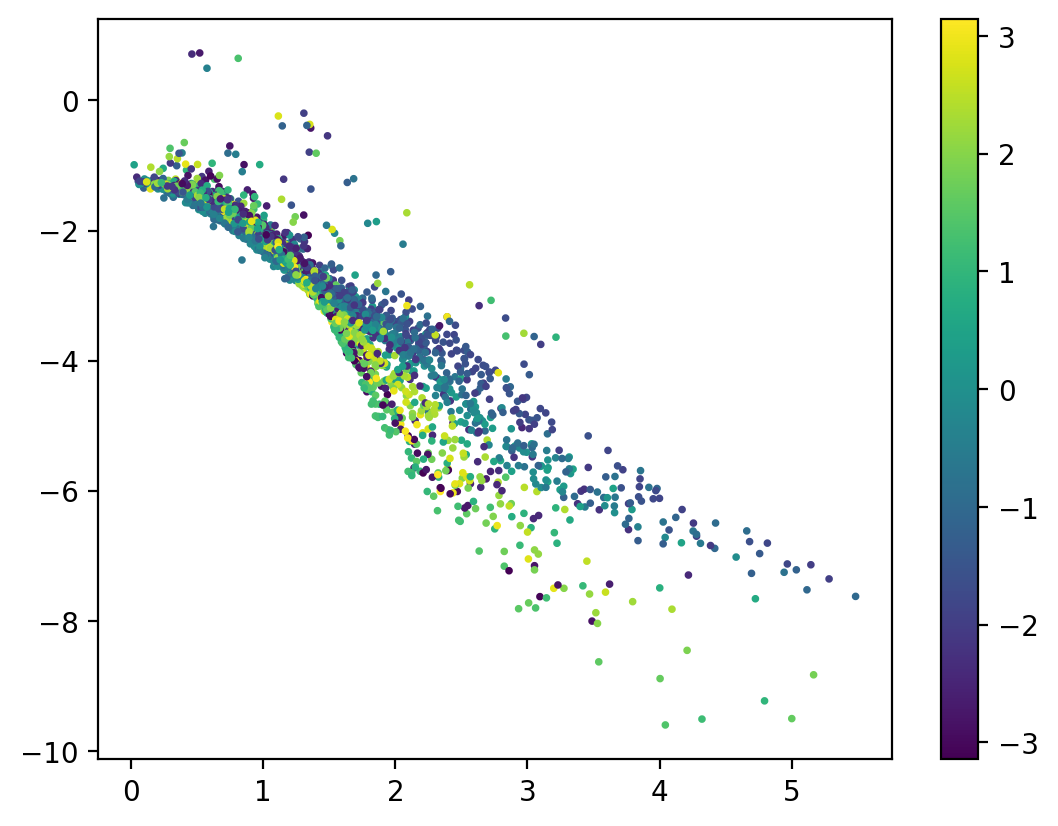

In [209]:
# plt.errorbar(r, z, zerr, c=theta, ls='', marker='')#, markersize=3)
plt.scatter(r, z, c=th, s=3)#, markersize=3)
plt.colorbar()

/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:180: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:184: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


[-0.         -0.93525026  0.43861541 -0.32389101 -0.33916928  0.26240487]
(63, 50)


Text(0, 0.5, 'ln Flux')

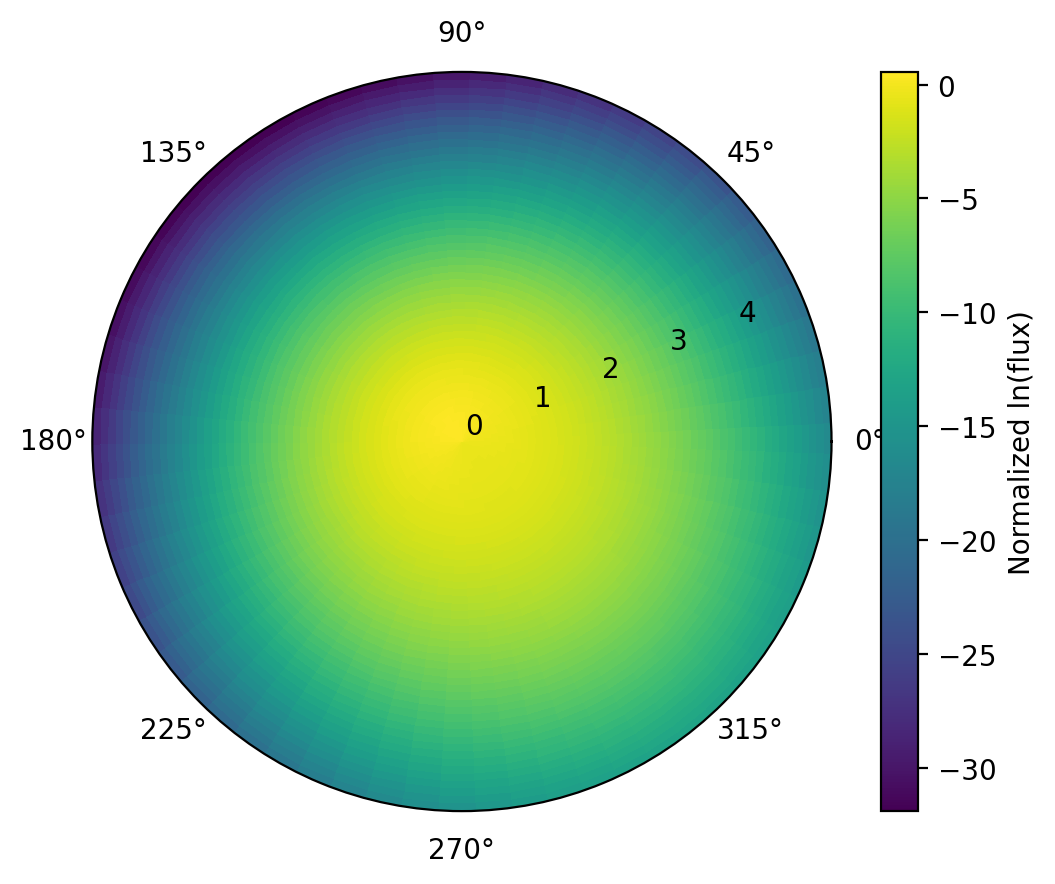

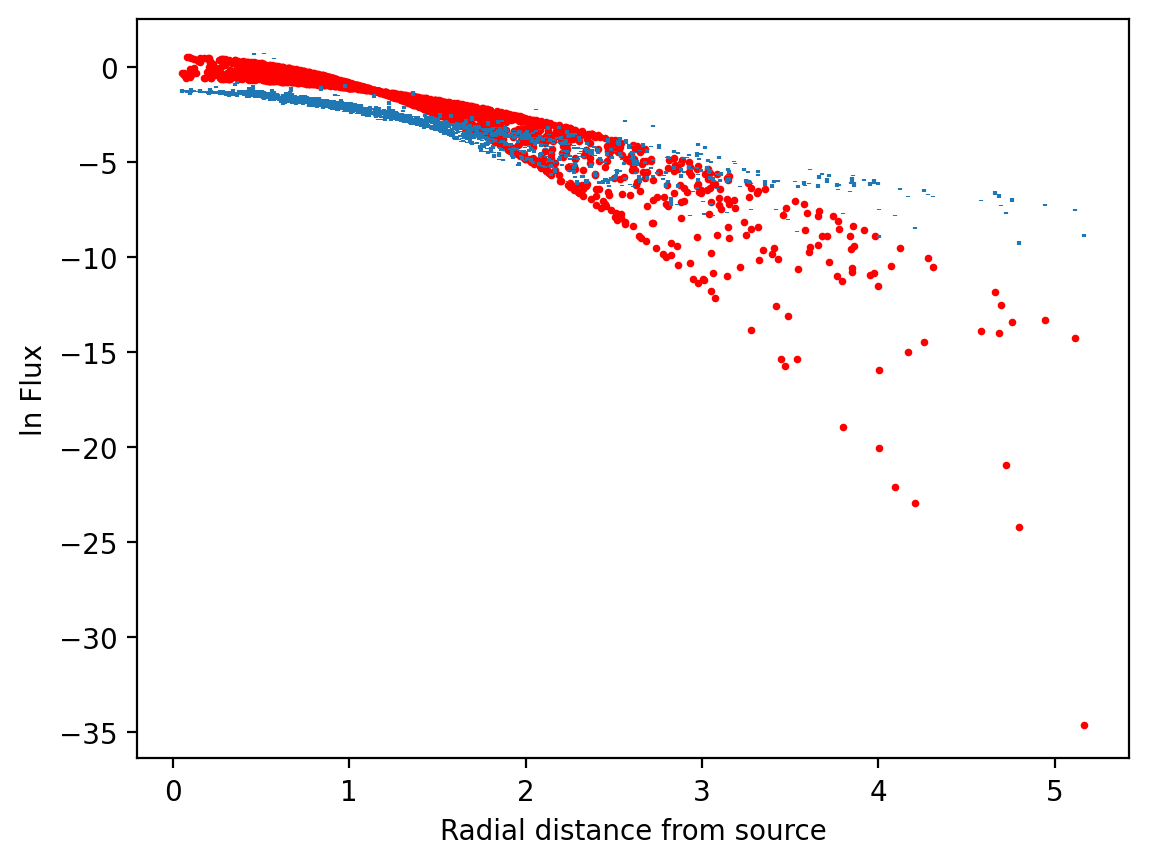

In [224]:
# gr = la.Polynomial1DGenerator(x_name='r', polyorder=3)#, 
gg = la.lnGaussian1DGenerator('r', stddev_prior=(1, .1))
gth = la.SinusoidGenerator(x_name='theta')
# gth2 = la.SinusoidGenerator(x_name='theta')
gblob = gg * gth

# print(gblob.prior_sigma)

gblob.fit(r=r, theta=theta, data=z, errors=zerr)
print(gblob.fit_mu)

sf1 = sf.copy()
sf1.psf = gblob
fig = sf1.plot_radial_psf()

plt.figure()
model_z = gblob.evaluate(r=r, theta=theta)
plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
plt.scatter(r, model_z, s=3, c='red')
plt.xlabel('Radial distance from source')
plt.ylabel('ln Flux')

Text(0.5, 1.0, 'Sigma Clipped points')

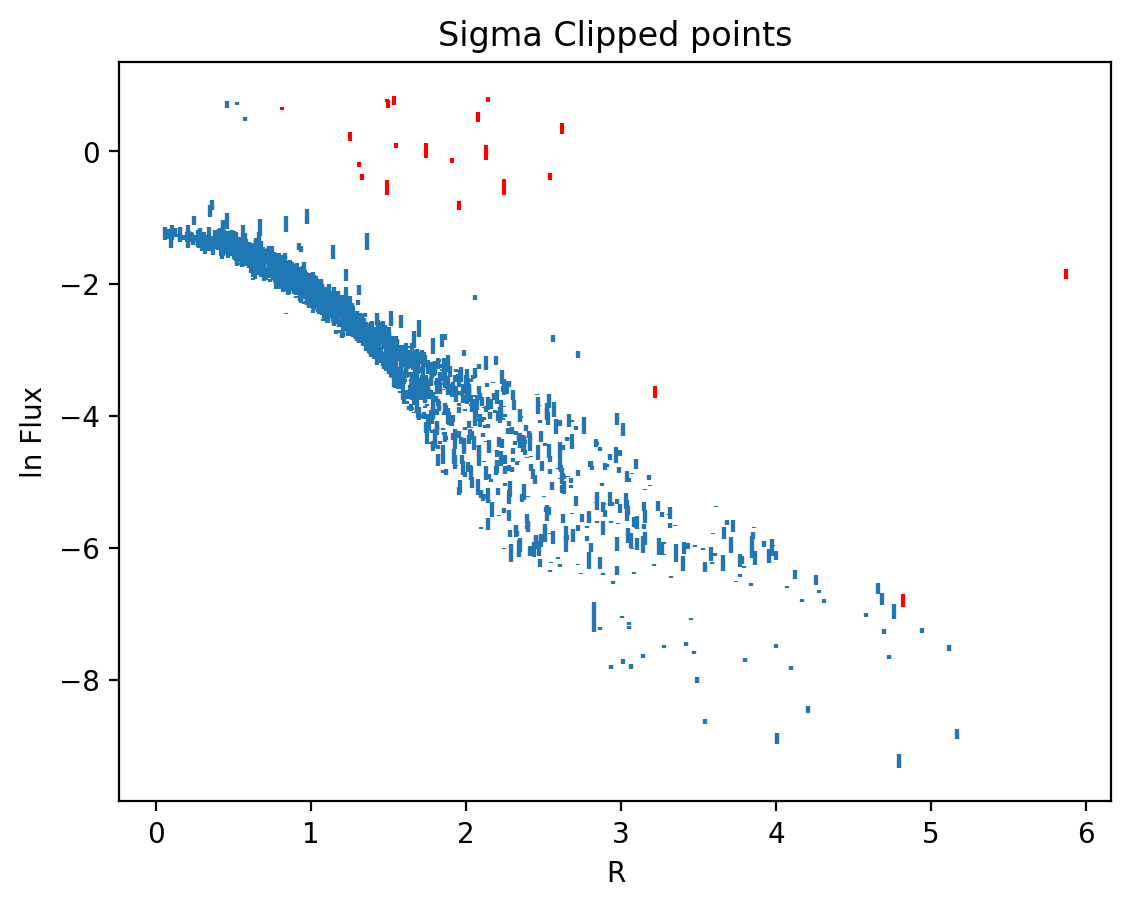

In [151]:
# red points are what got clipped out
# note that if you don't do the z<1, then you'll get a bunch of too-large fill values on the points that were nan
plt.errorbar(r[z<1].data, z[z<1].data, zerr[z<1].data, ls='', marker='', c='r')#, markersize=3)
plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
plt.xlabel('R')
plt.ylabel('ln Flux')
plt.title('Sigma Clipped points')

In [25]:
# I don't like splines, they get too iffy around the edges
centerfunc = la.Spline1DGenerator(np.linspace(0, 6, 5), x_name='r')
centerfunc.fit(r=r.data, data=z.data, errors=zerr.data)#, mask=~outliers)


plt.scatter(r, z, s=3)
plt.plot(r, centerfunc(r=r.data), c='r', marker='.', linestyle='')



AttributeError: 'memoryview' object has no attribute 'ravel'

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_40925/2777946737.py:4: RuntimeWarning: invalid value encountered in log
  z1 = np.log((sf.y / sf.max_contributor_flux))
/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_40925/2777946737.py:5: RuntimeWarning: invalid value encountered in log
  z11 = np.log((sf.data.ravel() / sf.max_contributor_flux))


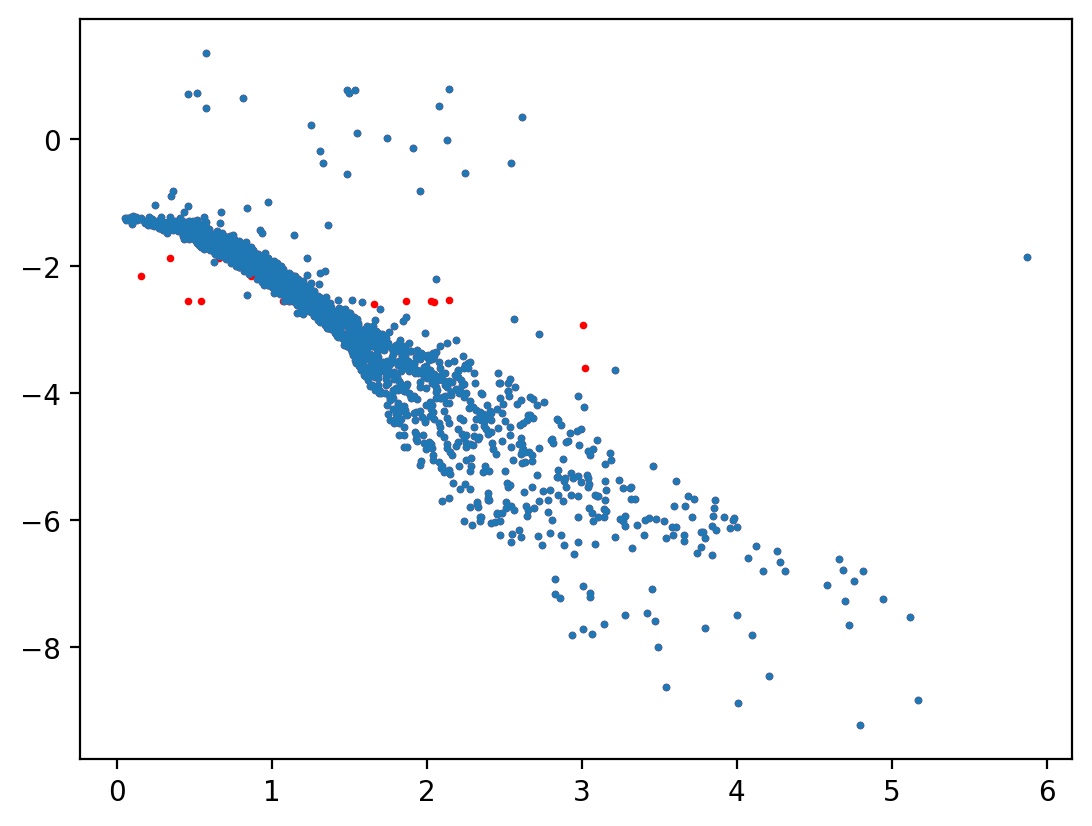

In [164]:
# deprecated, check for saturated pixels + prep for psf fitting
# now develop the psf fitting
# first step is to put things into radial coords
# z1 is normalized and in log space
z1 = np.log((sf.y / sf.max_contributor_flux))
z11 = np.log((sf.data.ravel() / sf.max_contributor_flux))
# z1 = np.log(np.hstack(sf.y / sf.max_contributor_flux))
ze1 = 2.5 * sf.yerr/sf.y * np.log(10)

# get dx, dy, r, and theta
dx = np.hstack(sf.R.ravel() - sf.df.iloc[sf.max_contributor_ind]['X0'].to_numpy())
dy = np.hstack(sf.C.ravel() - sf.df.iloc[sf.max_contributor_ind]['Y0'].to_numpy())
z1, ze1, dx, dy, = z1[sf.ss_mask], ze1[sf.ss_mask], dx[sf.ss_mask], dy[sf.ss_mask] 
r, theta = np.hypot(dx, dy), np.arctan2(dy, dx)

plt.scatter(r, z11[ss_mask], c='r', s=3)
plt.scatter(r, z1, s=3)



In [149]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py'>

/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py:261: UserWarning: Warning: converting a masked element to nan.
  x_sort, y_sort = np.array(x_sort), np.array(y_sort)


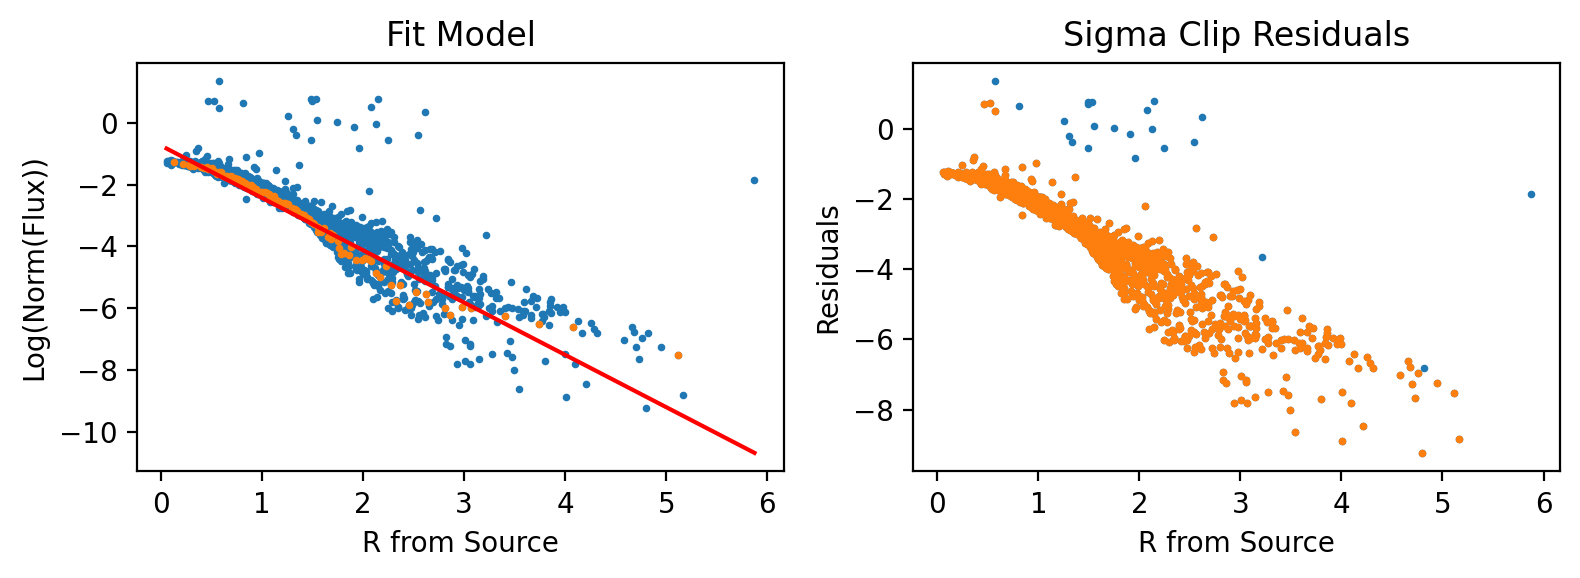

In [63]:
# (old) sigma clip before fitting! (plotting needs class implementation)
import operator
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip

core = (r < 1) & (z < -1)
wings = (r > 1) & (z < -1)
k = 4


# take the minimum 20% points
# xdata = np.log(dist_from_ss_mask])
xdata = r
ydata = z
# min_x, min_y = select_min_group(xdata, ydata, 10)
min_x, min_y = utils.select_nth_min_group(xdata, ydata, n_bin=20, k=k)

xmodel = np.linspace(min(xdata),max(xdata),100)
popt, pcov = curve_fit(utils.func_line, min_x, min_y)

if True:
    # plot to see how the model fit looks
    fig, ax = plt.subplots(1,2, figsize=[8,3])
    ax[0].scatter(xdata, ydata, s=3)
    ax[0].scatter(min_x, min_y, s=3)
    ax[0].plot(xmodel, utils.func_line(xmodel, *popt), c='r')
    ax[0].set_title('Fit Model')
    ax[0].set_xlabel('R from Source')
    ax[0].set_ylabel('Log(Norm(Flux))')
    # plt.ylim([0,2])

    # subtract model and sigma clip
    # resids = ydata - func_line(xdata, *popt)
    # filtered_data = sigma_clip(resids, sigma_upper=3, sigma_lower=5, maxiters=5)
    clipped = utils.iterative_sigma_clip(xdata, ydata, cenfunc=utils.custom_fit, sigma_clip_kwargs={'sigma_upper':5, 'sigma_lower':5}, cenfunc_kwargs={'n_bin':20, 'k':k, 'fit_func':utils.func_line})
    # ax[1].scatter(xdata, resids, s=3)
    # ax[1].scatter(xdata, filtered_data, s=3, c='r')
    ax[1].scatter(xdata, ydata, s=3)
    ax[1].scatter(clipped[0], clipped[1], s=3)
    ax[1].set_title('Sigma Clip Residuals')
    ax[1].set_xlabel('R from Source')
    ax[1].set_ylabel('Residuals')
    fig.tight_layout()
    plt.show()

    # clip_mask = ~filtered_data.mask
    # plt.scatter(xdata, ydata, s=3)
    # plt.scatter(xdata[clip_mask], ydata[clip_mask], s=3)

Core stddev:  (0.7185799860907627, nan)
(1, 0.1)


/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/models/gaussian.py:99: RuntimeWarning: invalid value encountered in scalar power
  stddev_err = -(self.sigma[1])/(2 * np.sqrt(2) * self.mu[1] ** (3/2))
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:180: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:184: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


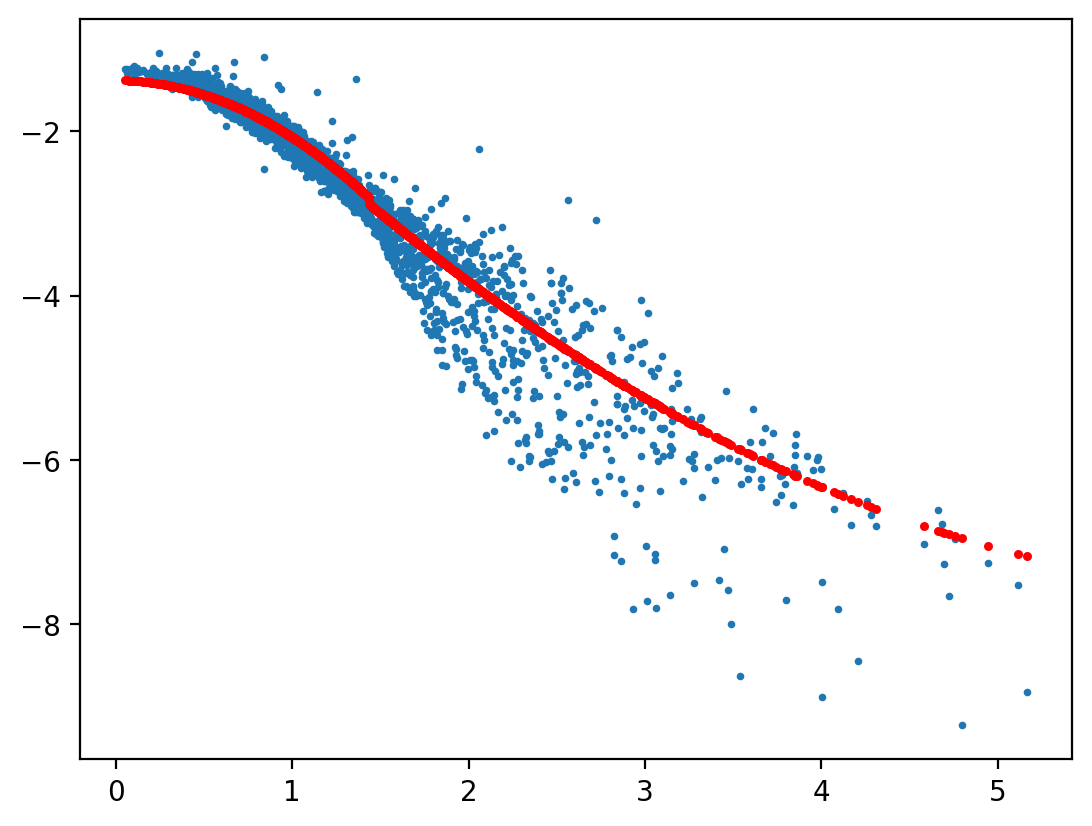

In [154]:
# Fit a gaussian to the core and line to the wings
core = (r < 1) & (z < -1)
wings = (r > 1) & (z < -1)

# add in sigma clip step in a bit
g1 = la.lnGaussian1DGenerator('r', stddev_prior=(1, .1))
# g1.fit(r=r, data=z, errors=zerr)
g1.fit(r=r[core], data=z[core], errors=zerr[core])
print("Core stddev: ", g1.stddev)

# Now do a bounded generator w/ updated core width
g2 = la.lnGaussian1DGenerator('r', stddev_prior=(g1.stddev[0], .1))
print(g1.stddev_prior)
g3 = la.Polynomial1DGenerator(x_name='r', polyorder=2)#, offset_prior=(0, 0))

# # systematics = p1 * p2
g_core = la.BoundedGenerator(g2, x_name='r', bounds=[(0, 2*g1.stddev[0])])
g_wings = la.BoundedGenerator(g3, x_name='r', bounds=[(2*g1.stddev[0], 100)])
combined = g_core + g_wings

# # g1.fit(r=r, data=z, errors=zerr)
# combined.fit(r=r[core], data=z[core])#, errors=zerr[core])
combined.fit(r=r, data=z, errors=zerr)
# print(combined.mu)

plt.scatter(r[z<-1], z[z<-1], s=3)
# plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
# plt.scatter(r[core], z[core], s=3)
# plt.scatter(r[wings], z[wings], s=3)
# plt.scatter(r[core], g1.evaluate(r=r[core]), c='r')
# plt.plot(r[wings], g2.evaluate(r=r[wings]), c='g')
# plt.show()
plt.scatter(r, combined.evaluate(r=r), c='r', s=5)



Notes 4/3/24

Okay! I got two basic psf-storing functions (for plotting a visualization of the psf, and for making a scene) working! I haven't tested them yet for psfs that take both r and theta as an input, and I need to do that.I have also given no thought to positional shifts on the detector, and will also need to do that. But progress!

To do:
 - incorporate theta dependence
 - test all psf functions for theta dependence
 - streamline how sigma clipping works
 - add helper functions to produce the ln(flux) data arrays
 - think about how to do position shifts on the detector
 - Try adding in an extra component to the design matrix that only kicks in for bright targets

(63, 50)


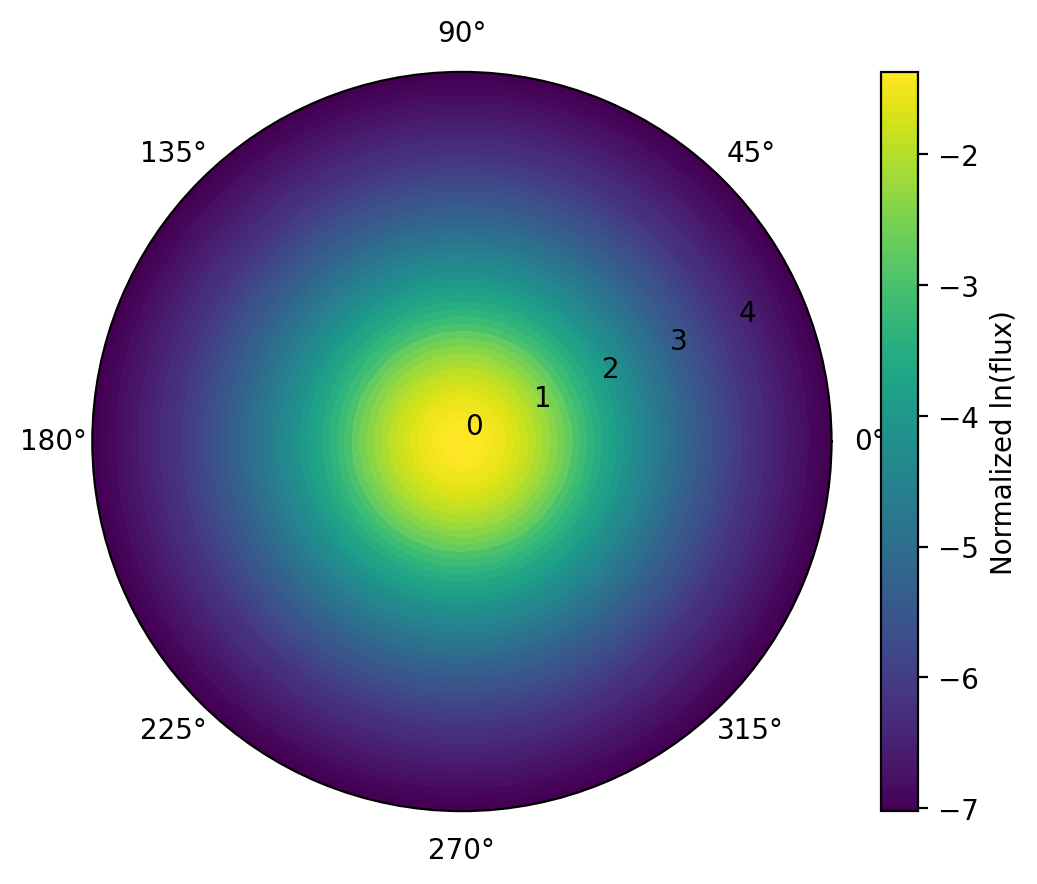

In [156]:
# # quick testing of psf functions
# imp.reload(utils)
# imp.reload(scene_fitter)
# from scene_fitter import SceneFitter
# sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs)

# # set the initial values to something reasonable
# sf.gaia_flux_coeff = gaia_flux_coeff  # 0.015366
# sf.initial_std = initial_std   # 1.1
# # print(sf.source_flux[:5])

# # get the initial single source mask
# ss_mask, single_source_data = sf.estimate_initial_ss_mask(tolerance=0.99, min_flux=50, update=True)

sf.psf = combined
fig = sf.plot_radial_psf()
scene = sf._get_psf_scene()
g_scene, _, _ = sf._get_gaussian_scene()

# compare contamination ratio from the new scene
cr, mci, mcf = sf.calc_contamination_ratio(scene)

# RIGHT HERE

Text(0.5, 1.0, 'Pixels Dominated by a Single Source')

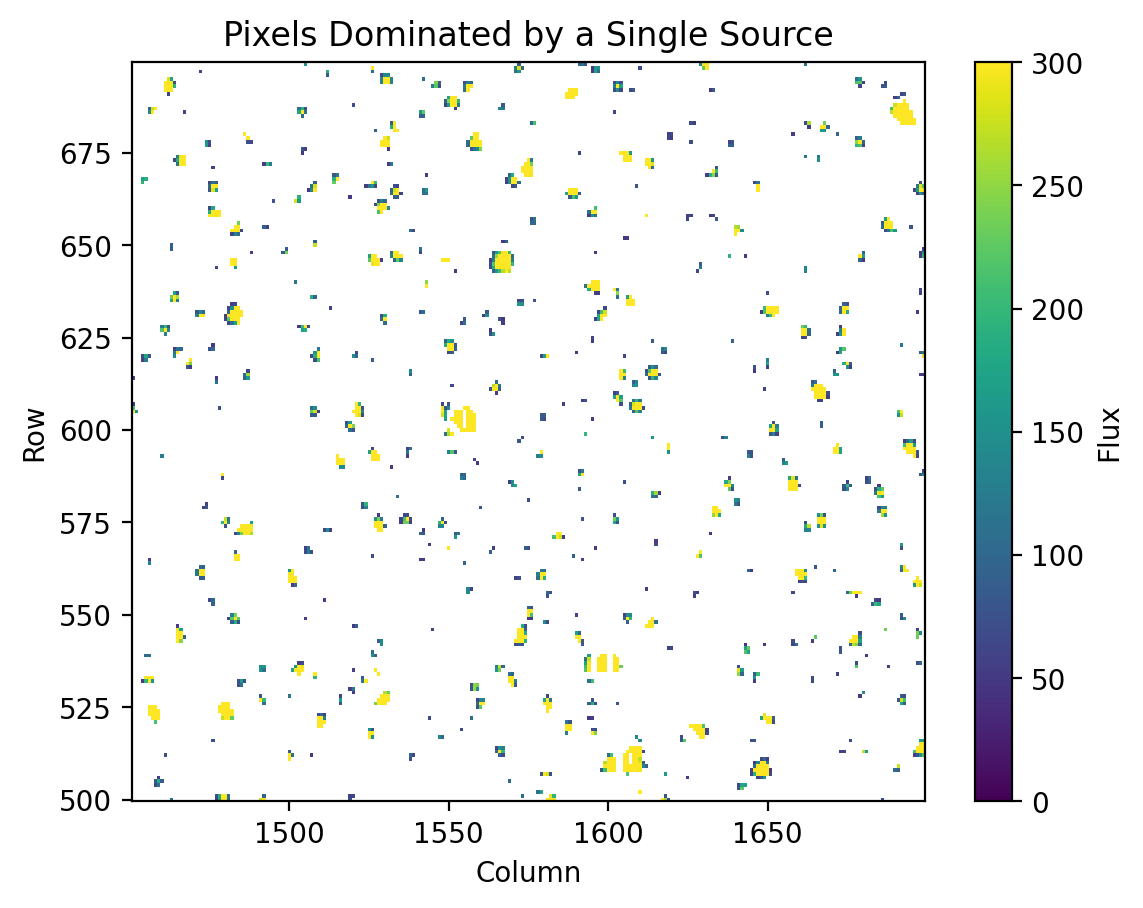

In [157]:
# check single source mask
temp = np.ma.masked_where(~sf.ss_mask.reshape(sf.shape), sf.data)


# # identify the sources that survive as single source contibutors
# single_source_inds = np.unique(max_contributor_ind[~single_source_data.mask.ravel()])
# print(str(len(single_source_inds)) + " single sources")

# plt.imshow(single_source_data, vmin=0, vmax=300)

fig = plt.figure()
ax = fig.add_subplot(111)
pc = ax.pcolormesh(sf.C, sf.R, temp, vmin=0, vmax=300) 
fig.colorbar(pc, label='Flux')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('Pixels Dominated by a Single Source')


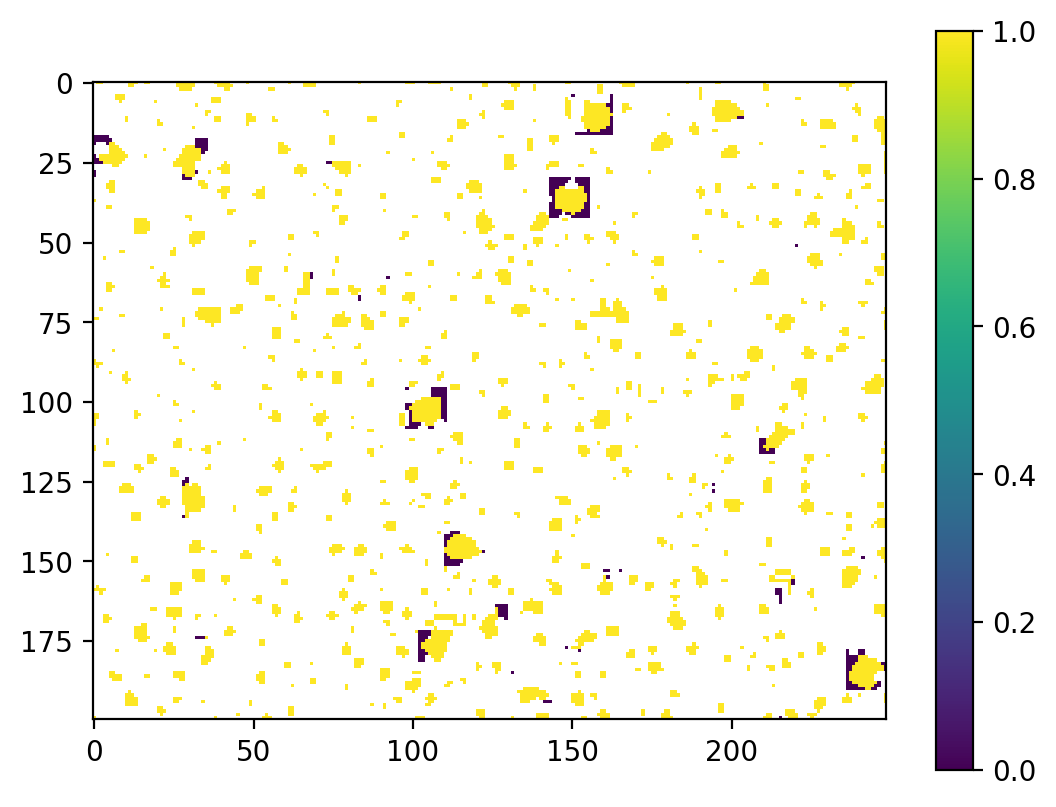

In [158]:
# compare contamination ratio from the new scene
cr, mci, mcf = sf.calc_contamination_ratio(scene)
gcr, gmci, gmcf = sf.calc_contamination_ratio(g_scene)

new_ss = cr > 0.95
temp = np.ma.masked_where(~new_ss.reshape(sf.shape), (gmci==mci).reshape(sf.shape))

# plt.imshow(cr.reshape(sf.shape))
# plt.imshow((cr-gcr).reshape(sf.shape)[:,:200])
plt.imshow(temp)
# plt.imshow((gmci==mci).reshape(sf.shape)[:,:200])
plt.colorbar()


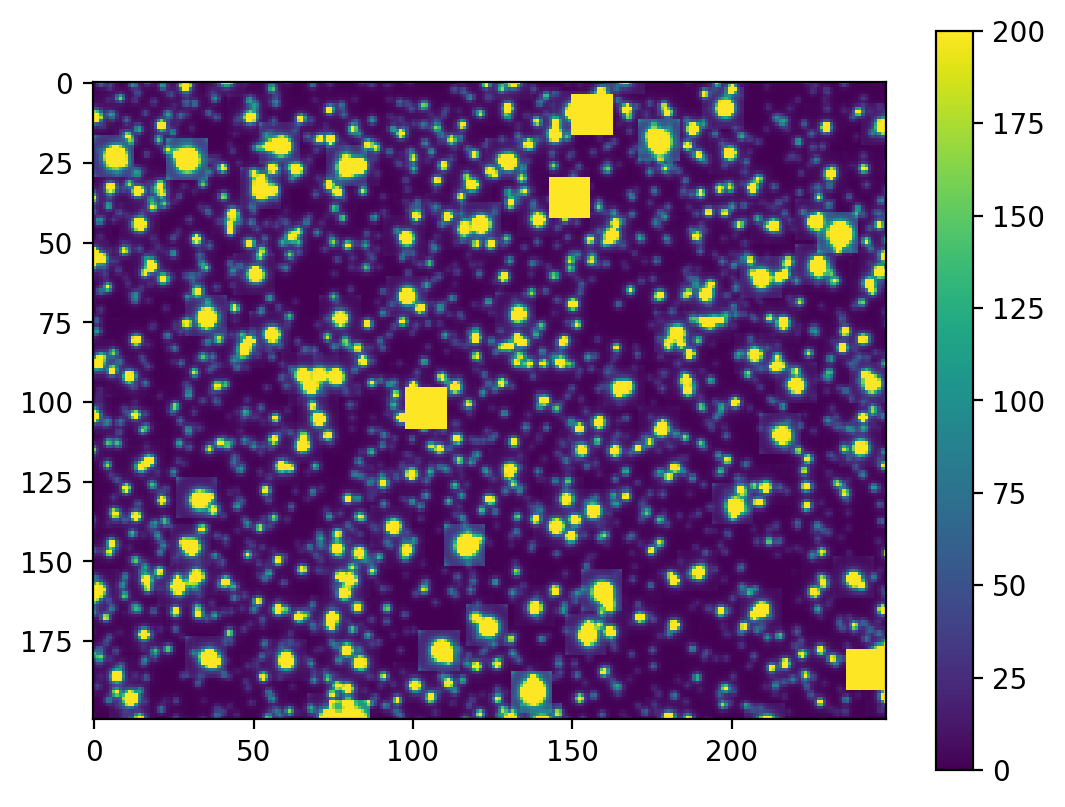

In [159]:
# problem! The psf background term is messing us up
plt.imshow(scene.tocoo().toarray().sum(axis=1).reshape(sf.shape),vmax=200)
plt.colorbar()

In [167]:
cr.shape

(49800, 1)

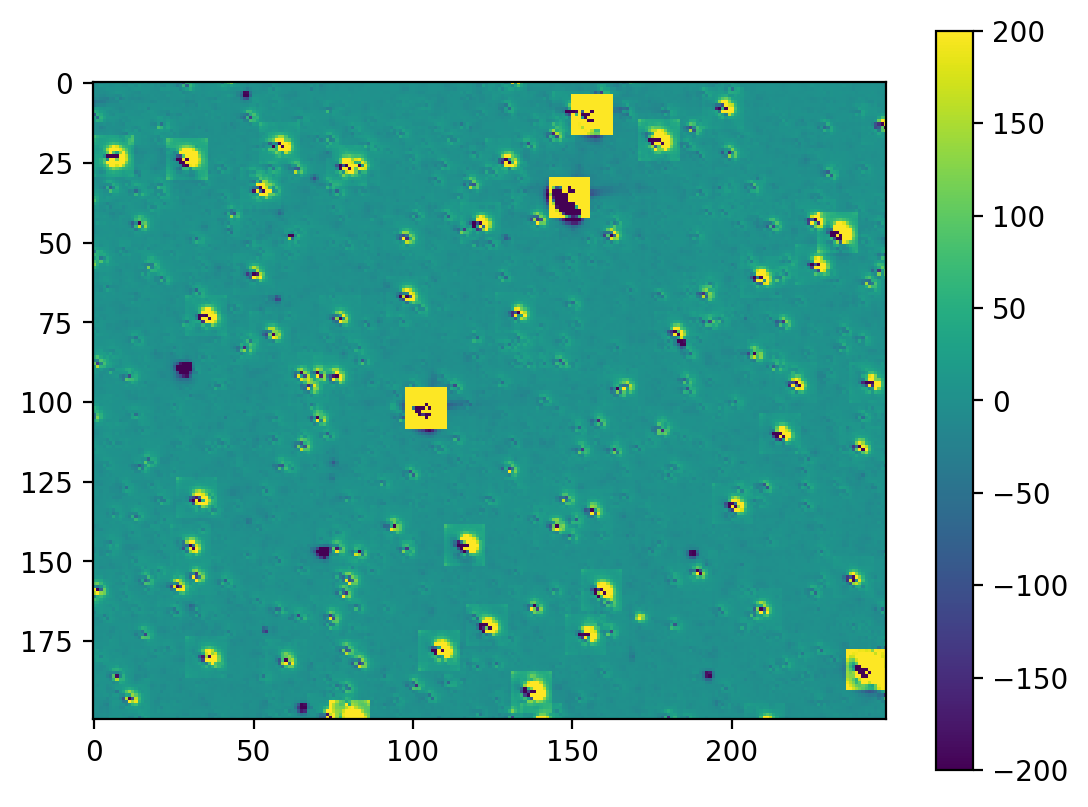

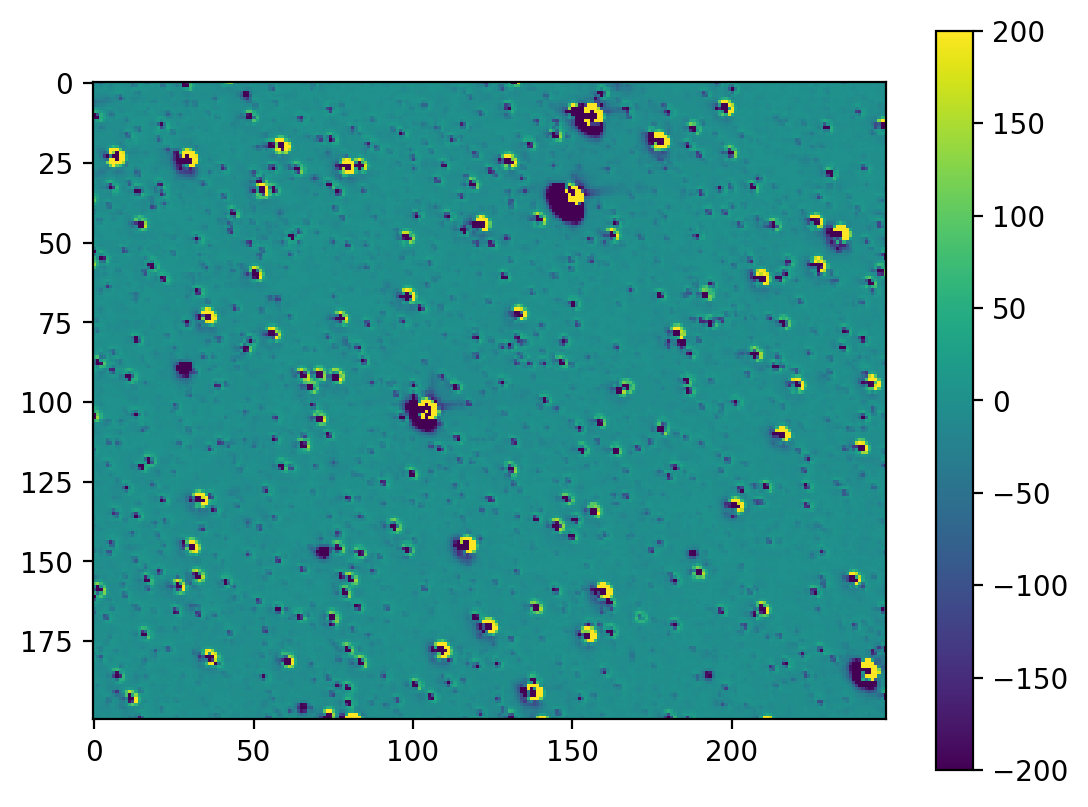

In [160]:
# compare how the new psf scene looks next to the raw gaussian scene!

# plt.imshow(scene.sum(axis=1).reshape(sf.shape), vmax=200)
# plt.imshow(sf.data, vmax=200)
plt.imshow(scene.sum(axis=1).reshape(sf.shape) - sf.data, vmin=-200, vmax=200)
plt.colorbar()
plt.show()

plt.imshow(g_scene.sum(axis=1).reshape(sf.shape) - sf.data, vmin=-200, vmax=200)
plt.colorbar()
plt.show()

In [121]:
gauss = utils.gaussian_2d(
            gR[:, :, None],
            gC[:, :, None],
            np.asarray(sf.df[x_col] % 1),
            np.asarray(sf.df[y_col] % 1),
            np.atleast_1d(std),
            np.atleast_1d(std),
        )

gauss.shape

(13, 13, 2783)

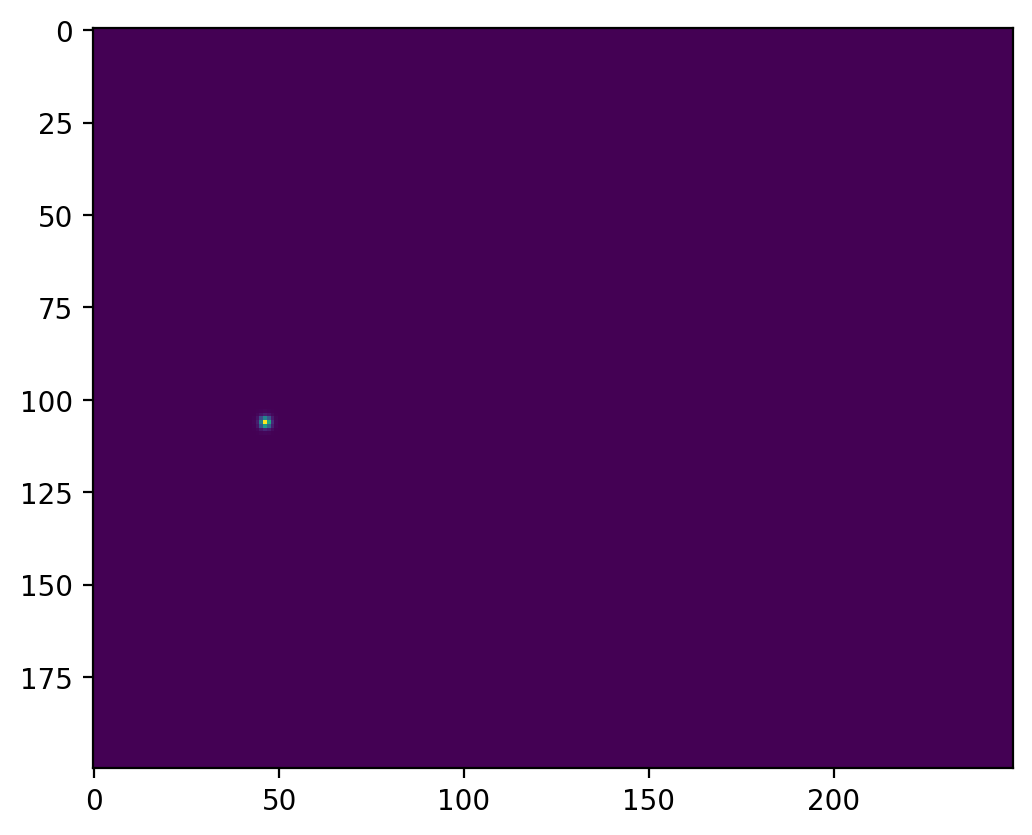

In [139]:
self.psf = combined

# lets see if we can make some plotting functions, etc out of this
# now let's try and make a scene

nstddevs=5
source_flux = self.source_flux
std = self.initial_std
x_col='X0'
y_col='Y0'

def _get_psf_scene(self, source_flux=None, std=None, x_col='X0', y_col='Y0', nstddevs=5):
        
    # row and column grids
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]

    # for just one slice of the scene
    ggR = gR[:,:,None] - np.asarray(self.df[x_col] % 1)
    ggC = gC[:,:,None] - np.asarray(self.df[y_col] % 1)

    rads = np.hypot(ggR, ggC)
    source = np.exp(self.pself.evaluate(r=rads.ravel()).reshape(ggR.shape))

    output = utils.SparseWarp3D(
                    source * source_flux,
                    gR[:, :, None] + np.asarray(np.floor(self.df[x_col] - self.R[0, 0])).astype(int),
                    gC[:, :, None] + np.asarray(np.floor(self.df[y_col] - self.C[0, 0])).astype(int),
                    self.shape,
                )

plt.imshow(output.tocoo().toarray()[:,5].reshape(self.shape))


In [ ]:
# gx = la.Polynomial1DGenerator(x_name='x', polyorder=1)
# gy = la.Polynomial1DGenerator(x_name='y', polyorder=1)

In [161]:
# maybe try some new lamatrix stuff now
gr = la.Polynomial1DGenerator(x_name='r', polyorder=3)#, 
gth = la.SinusoidGenerator(x_name='theta')
blob = gr * gth
blob.fit(r=r, theta=theta, data=z, errors=zerr)


# # g1.fit(r=r, data=z, errors=zerr)
# combined.fit(r=r[core], data=z[core])#, errors=zerr[core])
blob.fit_mu

gr.fit(r=r[z<1], data=z[z<1], errors=zerr[z<1])
gr.fit_mu
gr.equation


'\\[f(\\mathbf{r}) = w_{0} \\mathbf{r}^{0} + w_{1} \\mathbf{r}^{1} + w_{2} \\mathbf{r}^{2} + w_{3} \\mathbf{r}^{3}\\]'

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


(63, 50)


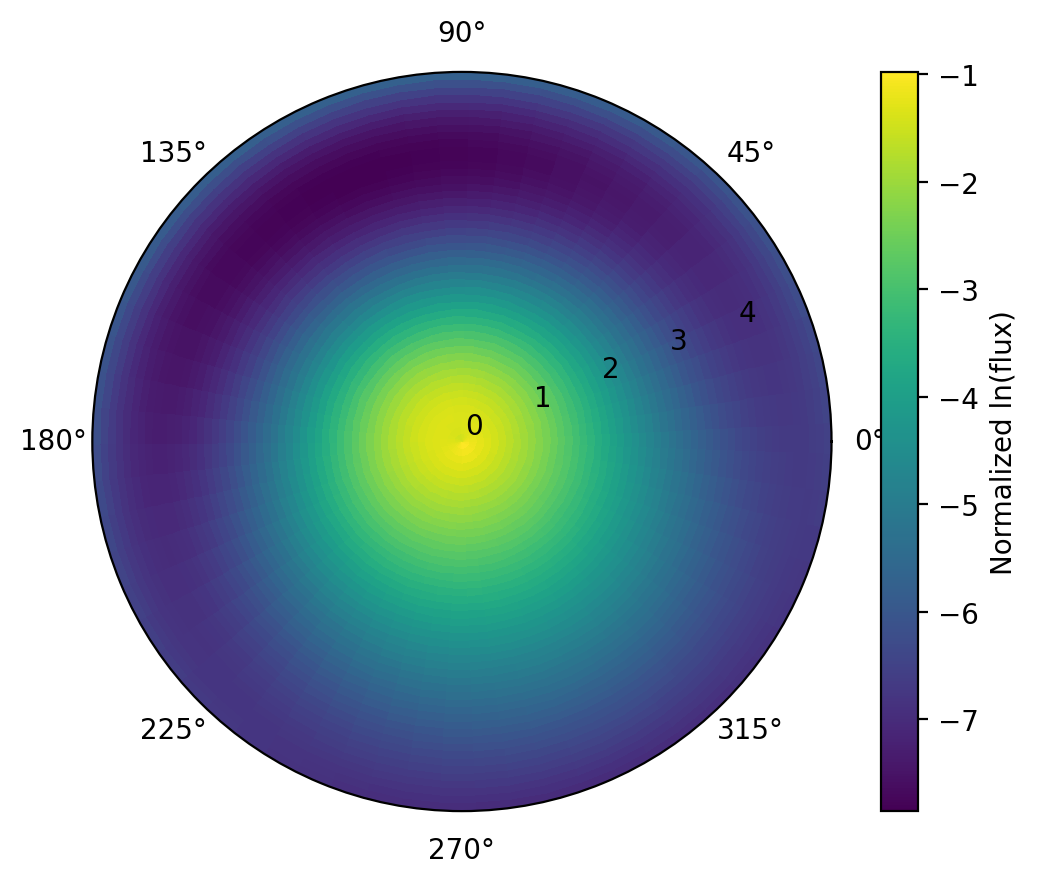

In [165]:
# quick testing of psf functions
imp.reload(utils)
imp.reload(scene_fitter)
from scene_fitter import SceneFitter
sf = SceneFitter(hdulist, df, cutout=cutout, wcs=wcs)

# set the initial values to something reasonable
sf.gaia_flux_coeff = gaia_flux_coeff  # 0.015366
sf.initial_std = initial_std   # 1.1
# print(sf.source_flux[:5])

# get the initial single source mask
ss_mask, single_source_data = sf.estimate_initial_ss_mask(tolerance=0.99, min_flux=50, update=True)

# sf.psf = combined
# fig = sf.plot_radial_psf()
# scene = sf._get_psf_scene()
# g_scene, _, _ = sf._get_gaussian_scene()

# # compare contamination ratio from the new scene
# cr, mci, mcf = sf.calc_contamination_ratio(scene)

gr = la.Polynomial1DGenerator(x_name='r', polyorder=3)#, 
gth = la.SinusoidGenerator(x_name='theta')
# gth2 = la.SinusoidGenerator(x_name='theta')
blob = gr * gth
blob.fit(r=r.data, theta=theta.data, data=z.data, errors=zerr.data)

sf1 = sf.copy()
sf1.psf = blob
fig = sf1.plot_radial_psf()

In [364]:
z

masked_array(data=[-1.4489530345884878, -4.167860458900829,
                   -3.050914366170884, ..., -2.1288202176315463,
                   -1.252447195164733, -5.187911015073425],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

**GET THAT SIGMA CLIPPING IMPLEMENTED**

And then figure out how to enforce the prior on the background be 0.

Text(0, 0.5, 'ln Flux')

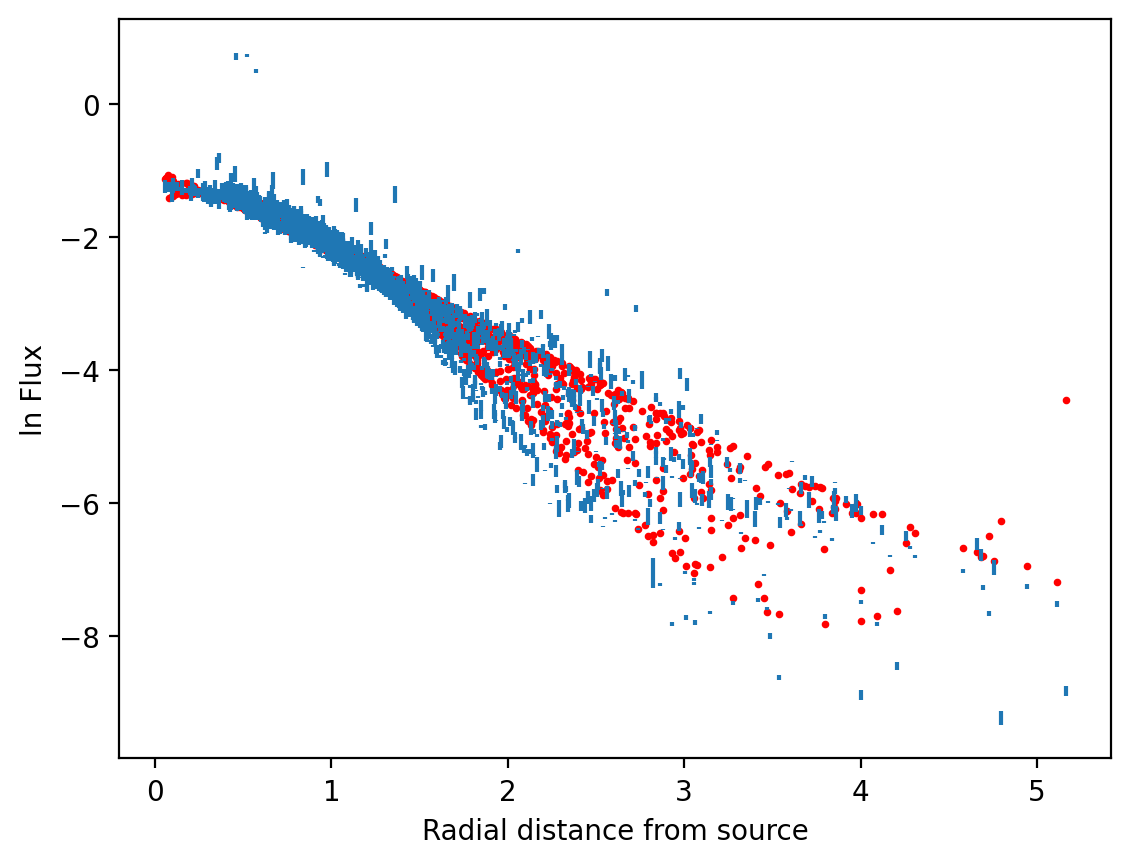

In [167]:
model_z = blob.evaluate(r=r, theta=theta)
plt.errorbar(r, z, zerr, ls='', marker='')#, markersize=3)
plt.scatter(r, model_z, s=3, c='red')
plt.xlabel('Radial distance from source')
plt.ylabel('ln Flux')

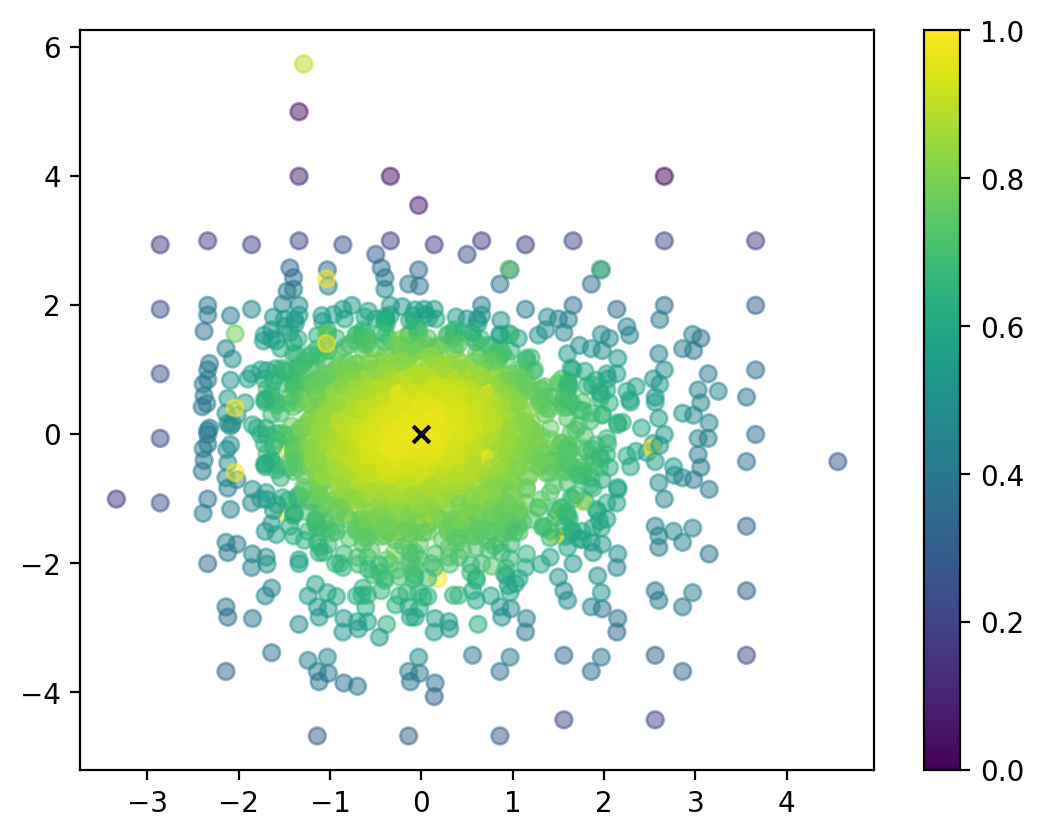

In [371]:
plt.scatter(dx, dy, c=z, alpha=.5, vmax=-1)
plt.scatter(0,0, c='black', marker='x')
plt.colorbar()

In [288]:
fig.gca()

<PolarAxesSubplot: >

In [261]:
sf.psf = combined
fig = sf.plot_radial_psf()
scene = sf._get_psf_scene()
g_scene, _, _ = sf._get_gaussian_scene()

# compare contamination ratio from the new scene
cr, mci, mcf = sf.calc_contamination_ratio(scene)

plot_radial_psf(self)

masked_array(data=[-1.10275232, -0.63115932, -0.59010059,  0.10163877,
                   -0.31313003,  1.22397687, -0.9898598 ,  0.16706279,
                   -0.04555726,  0.17598332, -0.11916065,  0.01775803,
                    0.06512025, -0.24052698,  0.18421534, -0.03171572],
             mask=False,
       fill_value=1e+20)

In [23]:
g1 = la.lnGaussian1DGenerator('core', stddev_prior=(1, .1))
g2 = la.Polynomial1DGenerator(x_name='wings', polyorder=1)#, 
(g1 + g2)

StackedIndependentGenerator(core, wings)[n, 4]
	lnGaussian1DGenerator(core)[n, 2] 
	Polynomial1DGenerator(wings)[n, 2] 

(1.102213966367835, nan)


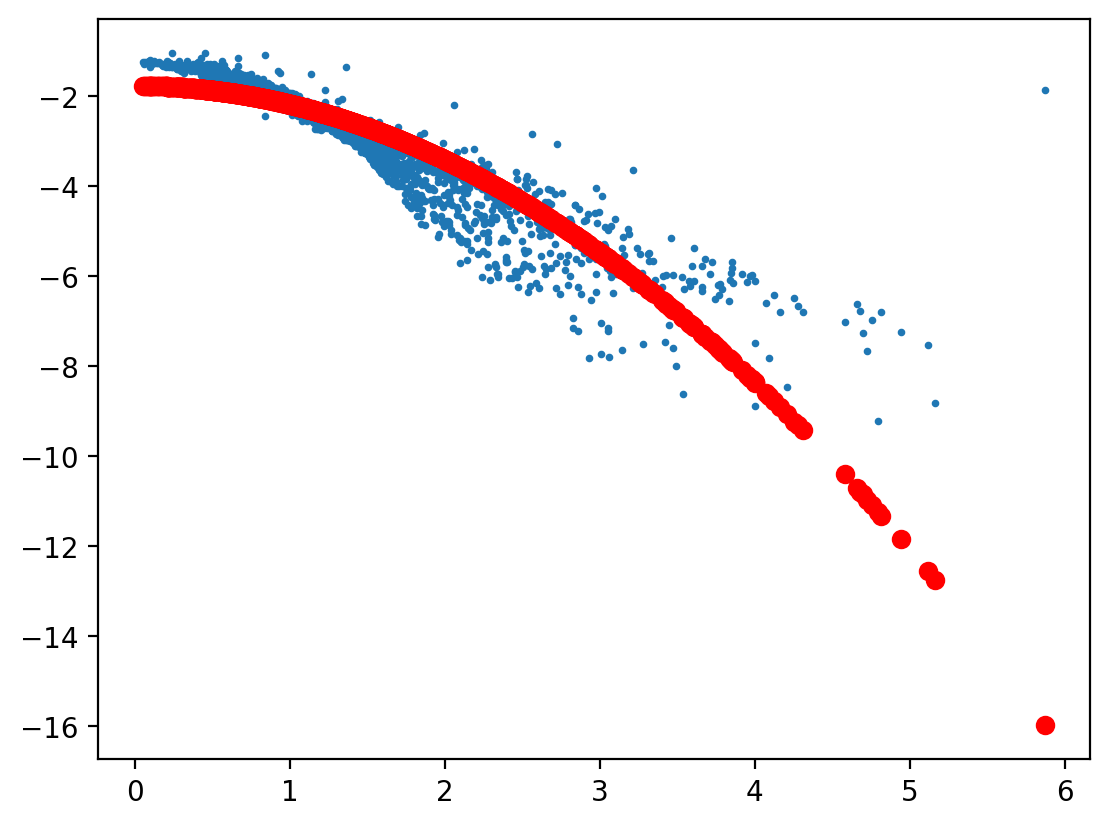

In [79]:
g1 = la.lnGaussian1DGenerator('r', stddev_prior=(1, .5))
g1.fit(r=r, data=z1, errors=ze1)
print(g1.stddev)

# g2 = la.Polynomial1DGenerator('r', polyorder=1)
# g2.fit(r=r[wings], data=z1[wings], errors=ze1[wings])

plt.scatter(r[z1<-1], z1[z1<-1], s=3)
# plt.scatter(r[core], z1[core], s=3)
# plt.scatter(r[wings], z1[wings], s=3)
plt.scatter(r, g1.evaluate(r=r), c='r')
# plt.plot(r[wings], g2.evaluate(r=r[wings]), c='g')
# plt.show()


[-1.23582239 -0.97125662 -0.         -1.878717  ]


/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:180: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/generator.py:184: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


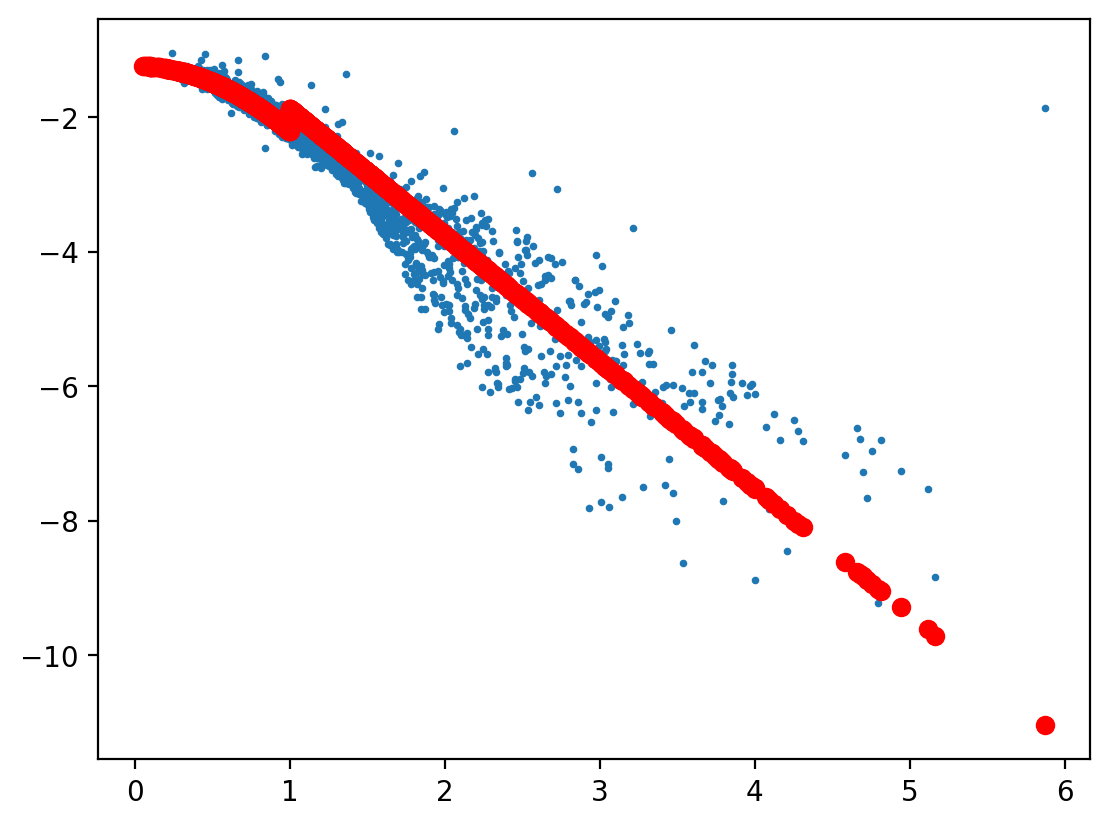

In [49]:
# try fitting with a bound generator
# add in sigma clip step in a bit
g1 = la.lnGaussian1DGenerator('r', stddev_prior=(1, .1))
g2 = la.Polynomial1DGenerator(x_name='r', polyorder=1)#, offset_prior=(0, 0))

# systematics = p1 * p2
g_core = la.BoundedGenerator(g1, x_name='r', bounds=[(0, 1)])
g_wings = la.BoundedGenerator(g2, x_name='r', bounds=[(1, 100)])
combined = g_core + g_wings

core = (r < 1)# & (z1 < -1)
wings = (r > 1)# & (z1 < -1)

# g1.fit(r=r, data=z1, errors=ze1)
# combined.fit(r=r[core], data=z1[core])#, errors=ze1[core])
combined.fit(r=r, data=z1, errors=ze1)
print(combined.mu)

# g2 = la.Polynomial1DGenerator('r', polyorder=1)
# g2.fit(r=r[wings], data=z1[wings], errors=ze1[wings])

plt.scatter(r[z1<-1], z1[z1<-1], s=3)
# plt.scatter(r[core], z1[core], s=3)
# plt.scatter(r[wings], z1[wings], s=3)
plt.scatter(r, combined.evaluate(r=r), c='r')
# plt.plot(r[wings], g2.evaluate(r=r[wings]), c='g')
# plt.show()



In [57]:
display.HTML(combined.equation)
# g_core.generator.stddev
# combined[0].generator.update_priors()
print(combined[0].generator.stddev_prior)

ValueError: Can not update priors before fitting.

[-1.77102268 -0.41156486]
[-1.77102268 -0.41156486]
(1.1022138318564236, nan)
(1, 0.1)


/Users/raeholcomb/Documents/GitHub/lamatrix/src/lamatrix/models/gaussian.py:99: RuntimeWarning: invalid value encountered in scalar power
  stddev_err = -(self.sigma[1])/(2 * np.sqrt(2) * self.mu[1] ** (3/2))


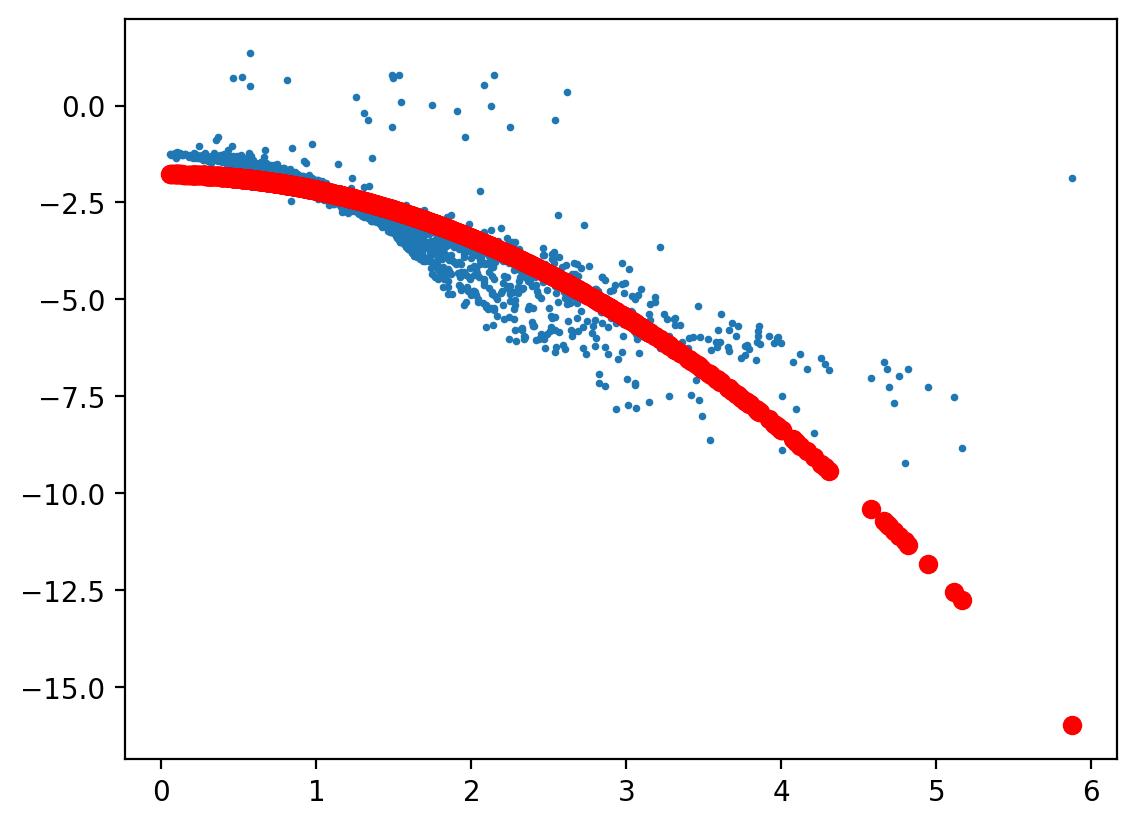

In [75]:
g1 = la.lnGaussian1DGenerator('r', stddev_prior=(1, .1))
# g_core = la.BoundedGenerator(g1, x_name='r', bounds=[(0, 1)])
g_core = g1

#fit
g_core.fit(r=r, data=z1, errors=ze1)
print(g_core.mu)

# update priors
g_core.update_priors()
print(g_core.mu)

# print(g_core.generator.stddev)
# print(g_core.generator.stddev_prior)
print(g_core.stddev)
print(g_core.stddev_prior)


plt.scatter(r, z1, s=3)
# plt.scatter(r, z1, s=3)
# plt.scatter(r[wings], z1[wings], s=3)
plt.scatter(r, g_core.evaluate(r=r), c='r')

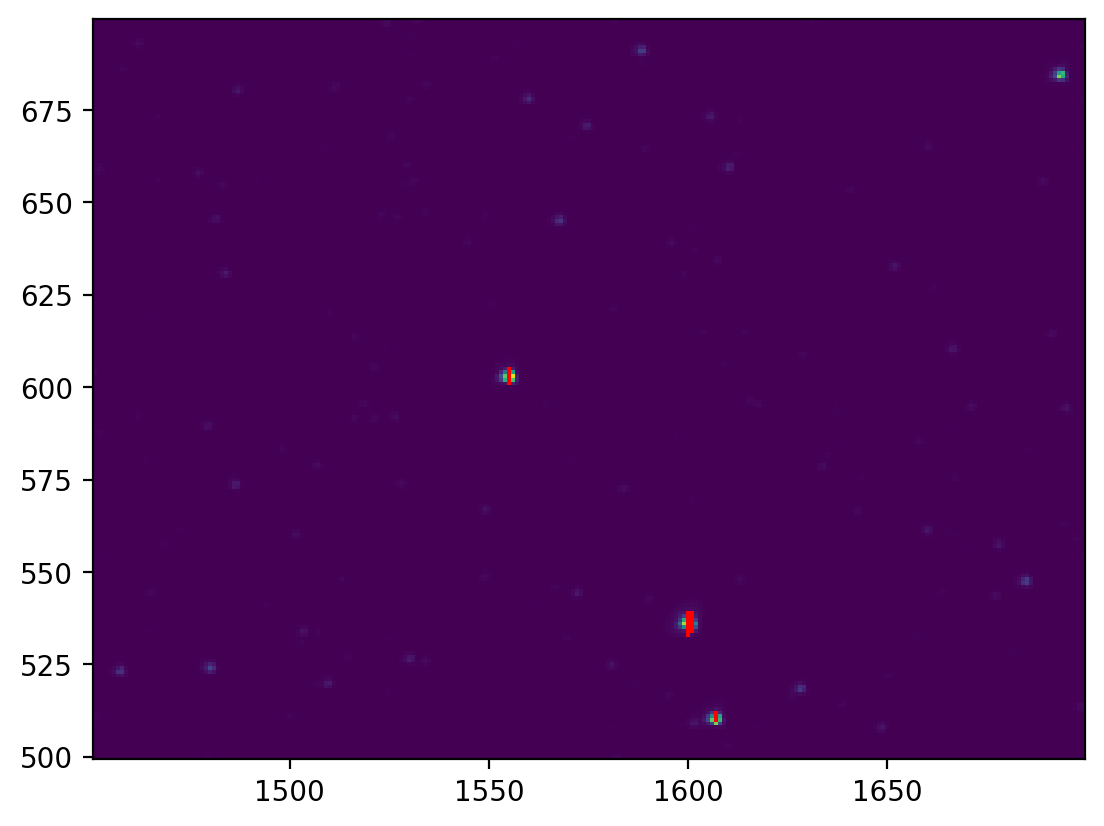

In [ ]:
# (already applied) make the saturation mask, then mask out pixels above and below
sat = sf.data > 1e5
# sat.reshape(R.shape)
pixel_mask = sat.copy()

def _check_saturation(data, saturation_limit=1e5, mask_adjacent=True):
    """Creates a mask of pixels that may be affected by saturation."""
    initial_mask = data > saturation_limit
    pixel_mask = initial_mask.copy()
    
    # If requested, check pixels above and below those with data > 1e5
    if mask_adjacent:
        for i in range(1, data.shape[0]):
            above_mask = initial_mask[i-1, :]
            below_mask = initial_mask[i, :]
            
            # Update pixel mask to include pixels above and below
            pixel_mask[i, :] |= above_mask
            pixel_mask[i-1, :] |= below_mask
    
    return pixel_mask


# def plot_saturation():
#     plt.pcolormesh(C, R, sf.data)


for i in range(1, sf.data.shape[0]):
    above_mask = sat[i-1, :]
    below_mask = sat[i, :]
    
    # Update pixel mask to include pixels above and below
    pixel_mask[i, :] |= above_mask
    pixel_mask[i-1, :] |= below_mask

sat_pixels = np.ma.masked_where(~sat, sf.data)
sad_adj = np.ma.masked_where(~pixel_mask, sf.data)

plt.pcolormesh(C, R, sf.data)
# plt.pcolormesh(C, R, sat_pixels, cmap='bwr', vmin=0, vmax=200)
plt.pcolormesh(C, R, sad_adj, cmap='bwr', vmin=0, vmax=200)
# plt.imshow(sat_pixels, color='red')

In [ ]:
# out of date?
def plot_data_with_mask(data, pixel_mask):
    fig, ax = plt.subplots()

    # Plot the data using plt.pcolormesh
    mesh = ax.pcolormesh(data, cmap='viridis')

    # Overlay the saturated pixel mask
    masked_data = np.ma.masked_where(pixel_mask == False, data)
    ax.pcolormesh(masked_data, cmap='gray', alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Data')

    # Set labels and title
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title('Data with Saturated Pixel Mask')

    plt.show()

# Example usage:
n = 10
m = 10
data = np.random.rand(n, m) * 1e6  # Example data
R, C = np.meshgrid(np.arange(n), np.arange(m))
pixel_mask = create_pixel_mask(data, R, C)

NameError: name 'create_pixel_mask' is not defined

--
--


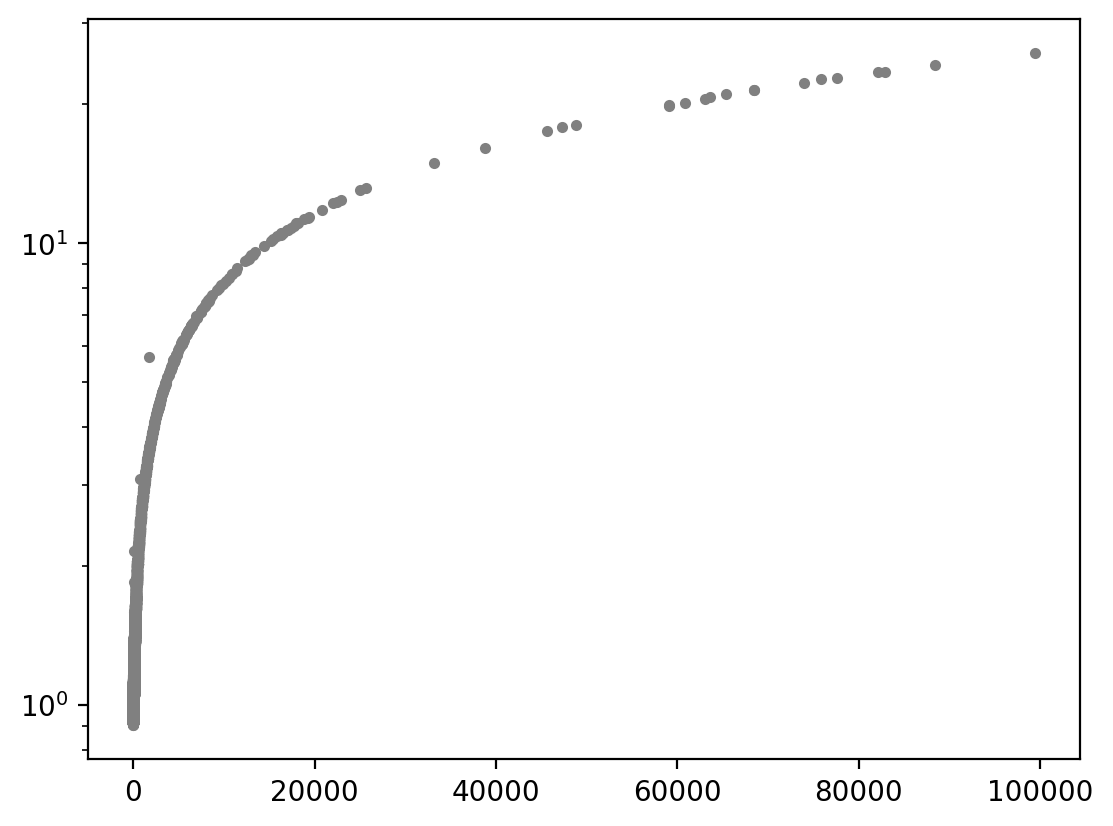

In [ ]:
# plt.errorbar(z1[core], ze1[core], color='grey', ls='', marker='.')
plt.errorbar(sf.y, sf.yerr, color='grey', ls='', marker='.')
plt.errorbar(sf.y[sf.y > 1e5], sf.yerr[sf.y > 1e5], color='red', ls='', marker='.')
plt.errorbar(sf.y[pixel_mask.ravel()], sf.yerr[pixel_mask.ravel()], color='red', ls='', marker='.')
# plt.errorbar(sf.y[sf.ss_mask][core], sf.yerr[sf.ss_mask][core], color='grey', ls='', marker='.')
plt.yscale('log')

print(sum(sf.y > 1e5))
print(sum(sf.y[ss_mask] > 1e5))


1978 1978


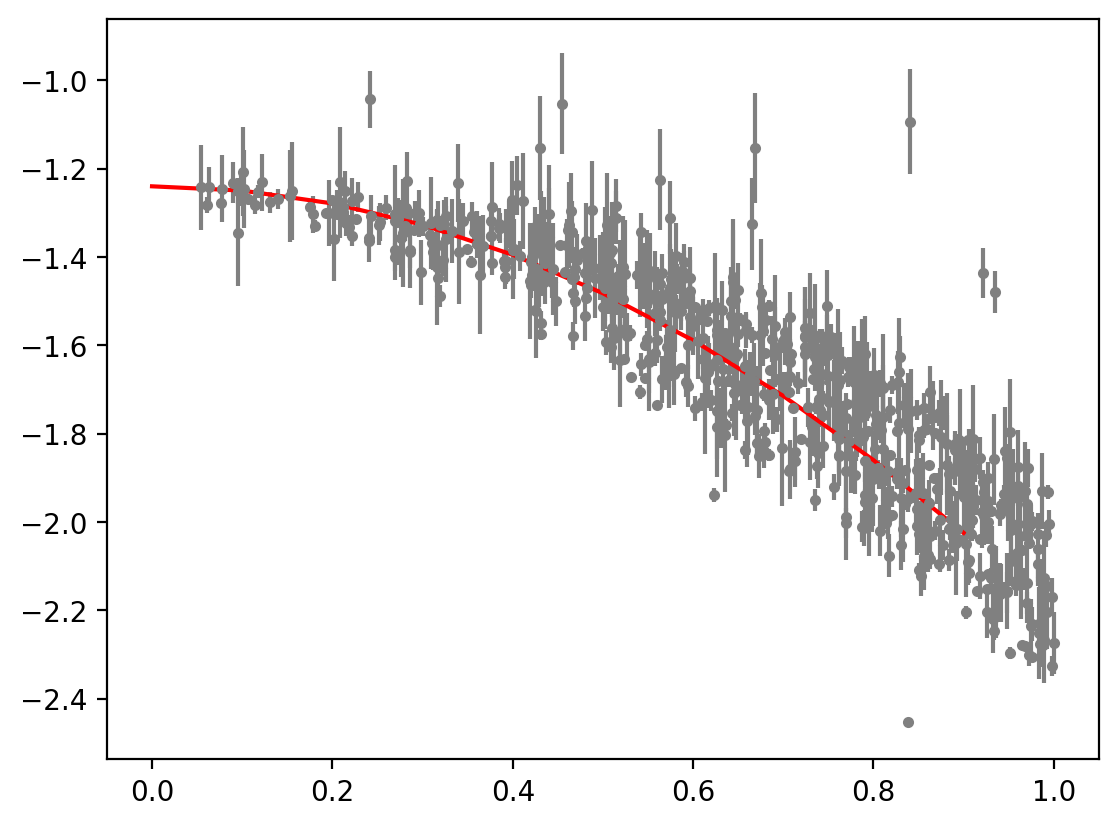

In [ ]:
# (deprecated) testing core fit
# g1 = la.lnGaussian1DGenerator('r')

saturated = sf.y[sf.ss_mask] > 1e5
saturated = sf.y[sf.ss_mask] > 9e4

print(len(saturated), len(r))

g1.fit(r=r[core], data=z1[core], errors=ze1[core])
plt.errorbar(r[core], z1[core], ze1[core], color='grey', ls='', marker='.')

plt.plot(np.arange(0,1, .1), g1.evaluate(r=np.arange(0,1, .1)), c='r')
# plt.errorbar(r, z1, ze1, color='grey', ls='', marker='.')
# plt.errorbar(r[saturated], z1[saturated], ze1[saturated], color='red', ls='', marker='.')
# plt.errorbar(r[pixel_mask.ravel()[sf.ss_mask]], z1[pixel_mask.ravel()[sf.ss_mask]], ze1[pixel_mask.ravel()[sf.ss_mask]], color='blue', ls='', marker='.')
# plt.errorbar(r[sat.ravel()[sf.ss_mask]], z1[sat.ravel()[sf.ss_mask]], ze1[sat.ravel()[sf.ss_mask]], color='red', ls='', marker='.')



In [48]:
# now do a second fit where you take the core out to two sigma
g3 = la.lnGaussian1DGenerator('r', stddev_prior=(combined.mu[], .1))
g4 = la.Polynomial1DGenerator(x_name='r', polyorder=1)#, offset_prior=(0, 0))

# systematics = p1 * p2
g_core = la.BoundedGenerator(g1, x_name='r', bounds=[(0, 1)])
g_wings = la.BoundedGenerator(g2, x_name='r', bounds=[(1, 100)])
combined = g_core + g_wings

core = (r < 1)# & (z1 < -1)
wings = (r > 1)# & (z1 < -1)

# g1.fit(r=r, data=z1, errors=ze1)
# combined.fit(r=r[core], data=z1[core])#, errors=ze1[core])
combined.fit(r=r, data=z1, errors=ze1)
print(combined.mu)

# g2 = la.Polynomial1DGenerator('r', polyorder=1)
# g2.fit(r=r[wings], data=z1[wings], errors=ze1[wings])

plt.scatter(r[z1<-1], z1[z1<-1], s=3)
# plt.scatter(r[core], z1[core], s=3)
# plt.scatter(r[wings], z1[wings], s=3)
plt.scatter(r, combined.evaluate(r=r), c='r')
# plt.plot(r[wings], g2.evaluate(r=r[wings]), c='g')
# plt.show()


SyntaxError: invalid syntax (66936731.py, line 2)

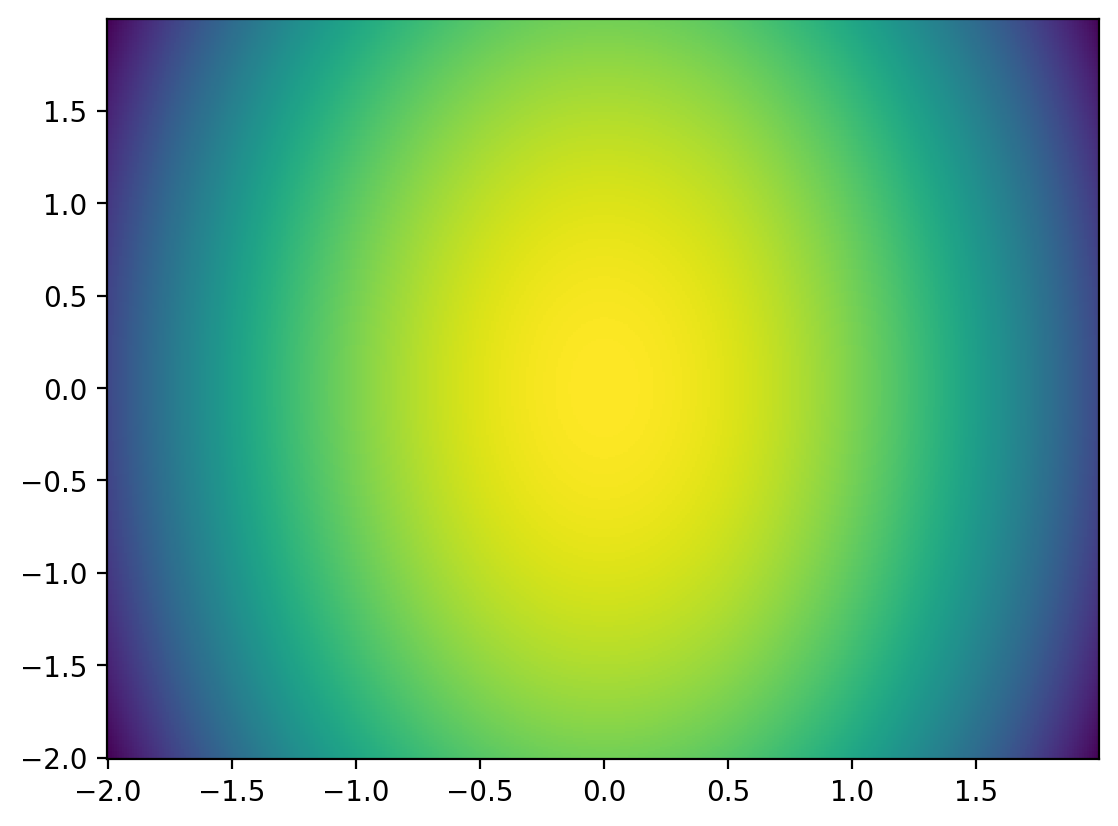

In [95]:
# psf = la.lnGaussian1DGenerator(stddev_prior=(1.1,.001))
# x = np.arange(0,2,.1)
# plt.plot(x, psf.evaluate(x=x))


psf = la.lnGaussian2DGenerator(stddev_x_prior=(1.1,.001), stddev_y_prior=(2.1,.001))
x = np.arange(-2,2,.01)
y = np.arange(-2,2,.01)

r1, c1 = np.meshgrid(x, y)
# plt.plot(x, psf.evaluate(x=x, y=y))

plt.pcolormesh(r1, c1, psf.evaluate(x=r1, y=c1).reshape((len(x), len(y))))
# plt.imshow(psf.evaluate(x=r1, y=c1).reshape((len(x), len(y))))

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


2789 2789
535 single sources


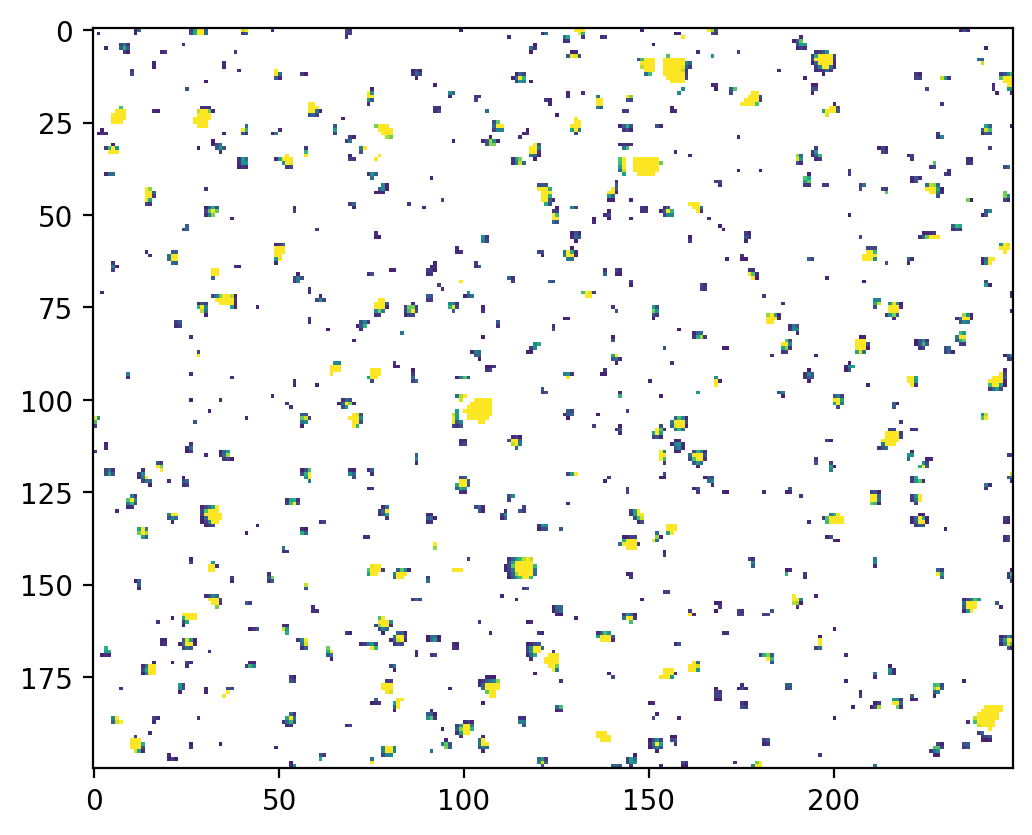

In [106]:
# make the single source mask
tolerance=0.99
min_flux=25

scene, _, _ = sf._get_gaussian_scene()
con_ratio = scene.max(axis=1) / scene.sum(axis=1)

# plt.imshow(con_ratio.reshape(sf.shape))
# plt.colorbar()

# for each pixel, identify the source that is the max contributor and grab its flux
max_contributor_ind = np.asarray(scene.argmax(axis=1))[:,0]
max_contributor_flux = sf.source_flux[max_contributor_ind]

# # normalize data by the flux of the max contributor to that pixel
# y_norm = sf.y / max_contributor_flux
# yerr_norm = sf.yerr / max_contributor_flux  # not sure if this is right? Check later


# Now we can select pixels by how bright they are and how "unique" their source contribution is!
m1 = np.array(con_ratio).squeeze() > tolerance
m2 = sf.y > min_flux

# masked_array of pixels with only a single source in them
ss_mask = (m1&m2)
single_source_data = np.ma.masked_where(~ss_mask.reshape(sf.shape), sf.data)
# single_source_data = np.ma.masked_where(~(m1&m2).reshape(sf.shape), sf.data)
# ss_mask = ~single_source_data.mask.ravel()

# identify the sources that survive as single source contibutors
single_source_inds = np.unique(max_contributor_ind[~single_source_data.mask.ravel()])
print(str(len(single_source_inds)) + " single sources")

plt.imshow(single_source_data, vmin=0, vmax=300)

In [107]:
# single_source_data = np.ma.masked_where(~ss_mask.reshape(sf.shape), sf.data)


# identify the sources that survive as single source contibutors
single_source_inds = np.unique(max_contributor_ind[~single_source_data.mask.ravel()])
print(str(len(single_source_inds)) + " single sources")

plt.imshow(single_source_data, vmin=0, vmax=300)

(49800, 2783)

In [15]:
display.HTML(g1.equation) 

In [ ]:
def fit_constant_flux_coeff(std=None, source_flux=None):
    # if std is None:
    #     std = self.initial_std
    # if source_flux is None:
    #     source_flux = self.gaia_flux
    scene, dfdx, dfdy = sf._get_gaussian_scene(std=std)
    flux = np.asarray(scene.sum(axis=1)).flatten()
    # flux = np.asarray(sf.get_flat_gaussian_model(std=std)).flatten()
    dfdx = np.array(dfdx).flatten()
    dfdy = np.array(dfdy).flatten()

    g1 = la.Polynomial1DGenerator('flux', polyorder=1)
    g2 = la.Polynomial1DGenerator('dfdx', polyorder=1)
    g3 = la.Polynomial1DGenerator('dfdy', polyorder=1)
    g = g1 + g2 + g3

    g.fit(flux=flux, dfdx=dfdx, dfdy=dfdy, data=sf.y, errors=sf.yerr)

    flux_coeff = g.mu[1]
    dx, dy = g.mu[3], g.mu[5]
    rmse = np.sqrt(np.mean((sf.y - g.evaluate(flux=flux, dfdx=dfdx, dfdy=dfdy))**2))

    return flux_coeff, dx, dy, rmse



In [27]:
g1.mu

array([ 9.68916712e+00,  9.64865262e-03,  3.41068503e-09, -3.55907566e-16])

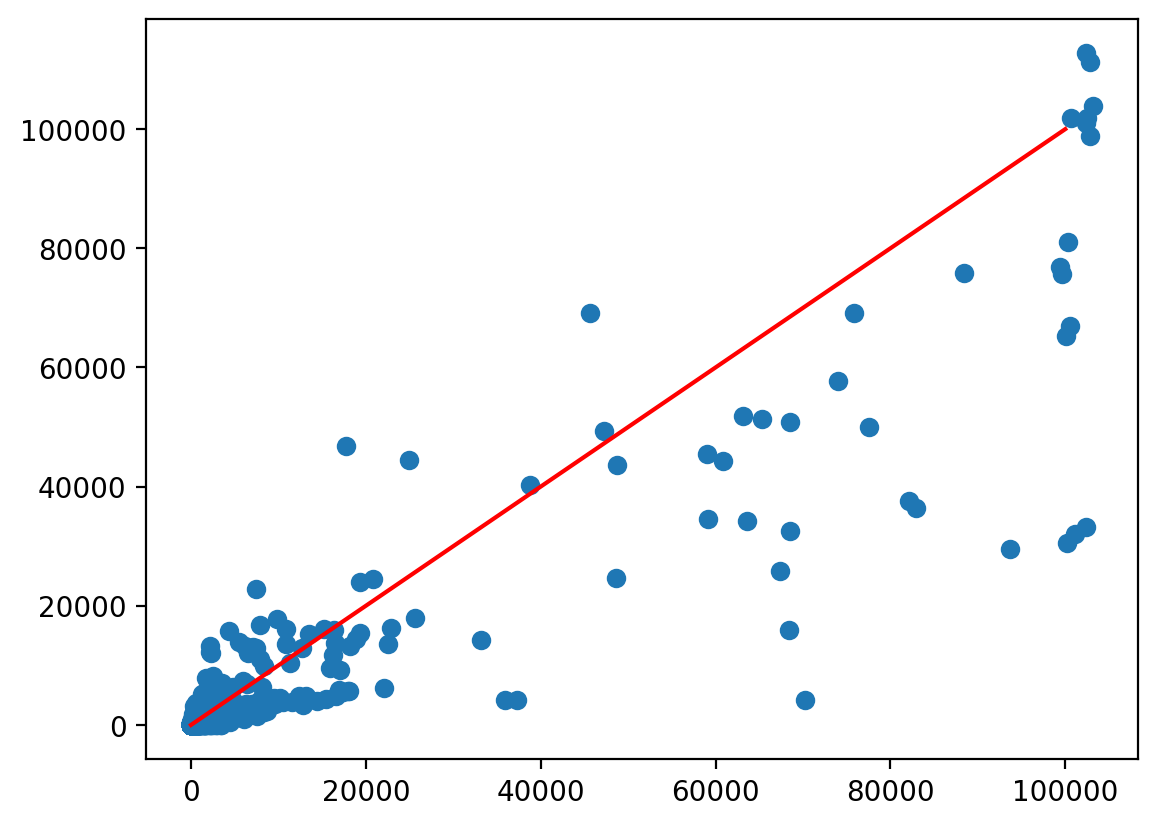

In [26]:
plt.scatter(sf.y, g1.evaluate(scene=scene))
plt.plot(np.arange(100000), np.arange(100000), c='r')
# plt.scatter()

In [12]:
display.HTML(g1.equation)

In [204]:
display.HTML(g.equation)  # look into mathjax
g.fit_sigma[1]

5.433765010240636e-07

# Discard

In [ ]:
# full testing
imp.reload(scene_fitter)
from scene_fitter import SceneFitter

df1 = df[bright_sources]
sf = SceneFitter(hdulist, df1, cutout=cutout, wcs=wcs)

# test scene
# s, ds_x, ds_y = sf._get_gaussian_scene(std=1.2)

# initial flux coeff estimation
# flux_coeff, dx, dy, rmse = sf.fit_constant_flux_coeff()
_, _, psfs = sf.update_initial_flux_coeff(np.arange(1, 1.5, 0.1), plot=True)
# sf.update_initial_flux_coeff(np.arange(0.8, 2., 0.1), plot=True)
gaia_flux_coeff = sf.gaia_flux_coeff
initial_std = sf.initial_std

# get the initial single source mask
ss_mask, single_source_data = sf.estimate_initial_ss_mask(tolerance=0.99, min_flux=50, update=True)

# plotting
# plt.pcolormesh(sf.R, sf.C, sf.get_flat_gaussian_model().reshape(sf.shape), vmax=20000)
# # plt.pcolormesh(sf.R, sf.C, s.sum(axis=1).reshape(sf.shape), vmax=20000)
# # plt.pcolormesh(sf.C.T, sf.R.T, s.sum(axis=1).reshape(sf.shapeT), vmax=20000)
# # plt.imshow(sf.y.reshape(sf.shape), vmax=200)
# plt.colorbar()
# plt.show()


# Broken TESS Clipping

## Broken TESS Clipping (new)

200

In [ ]:
deepcopy

In [452]:
def recover_cutout(R0, C0, naxis1, naxis2):
    cutout = [[R0 - (naxis1-1)/2, 
               R0 + (naxis1+1)/2],
              [C0 - (naxis2-1)/2,
               C0 + (naxis2+1)/2]]
    return cutout

def clip_TESS_fits(hdulist, cutout):
    """Clip a TESS hdu to a smaller one. Returns the WCS built from the original TESS file, since building one based off the clipped file seems to cause problems."""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(R0, C0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    # update header values
    for i in [1,2]:
        output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        output[i].header['CRPIX1'] = R0
        output[i].header['CRPIX2'] = C0
        output[i].header['CRVAL1'] = ra0
        output[i].header['CRVAL2'] = dec0

    return output, wcs, R, C

def get_cutout_and_catalog(hdulist, cutout):
    """Queries a catalog for a cut out of a tess file. Currently configured for TESS cutouts."""
    # make a output file
    output = deepcopy(hdulist)

    # caclulate new pixel grid
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    R0, C0 = R[:, 0].mean(), C[0].mean()

    # cut out the data
    output[1].data = hdulist[1].data[R, C]
    output[2].data = hdulist[2].data[R, C]
    # output[1].data = hdulist[1].data[C, R]
    # output[2].data = hdulist[2].data[C, R]

    # make a wcs
    wcs = WCS(hdulist[1].header)
    c = wcs.pixel_to_world(R0, C0)
    ra0, dec0 = c.ra.deg, c.dec.deg

    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
    radius = np.max(c.separation(cs).deg)

    # update header values
    for i in [1,2]:
        output[i].header['NAXIS1'] = cutout[0][1] - cutout[0][0]
        output[i].header['NAXIS2'] = cutout[1][1] - cutout[1][0]
        output[i].header['CRPIX1'] = R0
        output[i].header['CRPIX2'] = C0
        output[i].header['CRVAL1'] = ra0
        output[i].header['CRVAL2'] = dec0
    
    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # I bet this "round" step is the culprit for why the weights look weird later
    # instead, we should keep a rounded and an unrounded version
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # # this looks like it's taking a 3 pixel buffer around the image
    # k = (
    #     (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
    #     & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
    #     & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
    #     & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    # )
    # df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return output, wcs, df


def get_catalog(hdulist, wcs, R, C):
    """Queries a catalog for a given hdu. Currently configured for TESS cutouts."""
    # wcs = WCS(hdulist[1].header)
    R0 = hdulist[1].header['CRPIX1']
    C0 = hdulist[1].header['CRPIX2']
    cutout = recover_cutout(R0, C0, hdulist[1].header['NAXIS1'], hdulist[1].header['NAXIS2'])   
    
    R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
    l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
    c = wcs.pixel_to_world(R0, C0)
    cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
    print(cs)
    # cs = wcs.pixel_to_world(R0 - hdulist[1].header['NAXIS1']/2, 
    #                         C0 - hdulist[1].header['NAXIS2']/2)
    ra0, dec0 = c.ra.deg, c.dec.deg
    print(ra0, dec0)
    print(hdulist[1].header['CRVAL1'], hdulist[1].header['CRVAL2'])    
    # ra0 = hdulist[1].header['CRVAL1']
    # dec0 = hdulist[1].header['CRVAL2']
    radius = np.max(c.separation(cs).deg)

    # the query
    df = utils.get_sky_catalog_psf(
        ra0,
        dec0,
        radius=radius,
        grpmagnitude_range=(-3, 16),
        gaia_keys=[
            "source_id",
            "ra",
            "dec",
            "parallax",
            "pmra",
            "pmdec",
            "radial_velocity",
            "ruwe",
            "phot_rp_mean_flux",
            "teff_gspphot",
            "logg_gspphot",
            "phot_g_mean_flux", 
            "phot_g_mean_mag",
        ],
        epoch=Time(hdulist[0].header["DATE-OBS"]),
    )

    # format the catalog
    df[["X", "Y"]] = np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T
    df[["X0", "Y0"]] = np.round(np.asarray(
        wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
    ).T, 2)

    # # this looks like it's taking a 3 pixel buffer around the image
    # k = (
    #     (df.X0 > R0 - hdulist[1].header['NAXIS1']/2 - 3)
    #     & (df.X0 < R0 + hdulist[1].header['NAXIS1']/2 + 3)
    #     & (df.Y0 > C0 - hdulist[1].header['NAXIS2']/2 - 3)
    #     & (df.Y0 < C0 + hdulist[1].header['NAXIS2']/2 + 3)
    # )
    # df = df[k]
    df = df.sort_values('phot_rp_mean_flux')
    df = df.drop_duplicates(['X0', 'Y0'], keep='first')
    df = df.reset_index(drop=True)

    return df




In [428]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-wcs/src/pandorawcs/sandbox/../utils.py'>

In [367]:
# plt.imshow(data - hdu1[1].data)
# plt.show()

print(R0, C0)
print(hdu1[1].header['CRPIX1'], hdu1[1].header['CRPIX2'])

print(ra0, dec0)
print(hdu1[1].header['CRVAL1'], hdu1[1].header['CRVAL2'])

# plt.pcolormesh(R, C, data)
# plt.show()
# plt.pcolormesh(R1, C1, hdu1[1].data)
# plt.show()


599.5 1575.0
599.5 1575.0
34.99298500623635 37.80287095586731
34.99298500623635 37.80287095586731


In [377]:
print(cutout)
print([[R0 - (hdu1[1].header['NAXIS1']-1)/2, 
               R0 + (hdu1[1].header['NAXIS1']+1)/2],
              [C0 - (hdu1[1].header['NAXIS2']-1)/2,
               C0 + (hdu1[1].header['NAXIS2']+1)/2]])

[[500, 700], [1451, 1700]]
[[500.0, 700.0], [1451.0, 1700.0]]


In [453]:
# NEW open tess cutout
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "../../../data/tess2022329190202-s0058-1-2-0247-s_ffic.fits"
)
# cutout = [[1500,1700], [1501,1700]]
# cutout = [[1500,1700], [1451,1700]]
cutout = [[500,700], [1451,1700]]

# hdu1, wcs, R, C = clip_TESS_fits(hdulist, cutout)
# df = get_catalog(hdu1, wcs, R, C)
hdu1, wcs, df = get_cutout_and_catalog(hdulist, cutout)


Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


In [449]:
hdulist[1].header['CRPIX1']
hdu1[1].header['CRPIX1']

599.5

In [406]:
# R0 = hdu1[1].header['CRPIX1']
# C0 = hdu1[1].header['CRPIX2']
# cutout = [[R0 - hdu1[1].header['NAXIS1']/2, 
#             R0 + hdu1[1].header['NAXIS1']/2],
#             [C0 - hdu1[1].header['NAXIS2']/2,
#             C0 + hdu1[1].header['NAXIS2']/2]]


# R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
# l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
# c = wcs.pixel_to_world(R0, C0)
# cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
# # cs = wcs.pixel_to_world(R0 - hdu1[1].header['NAXIS1']/2, 
# #                         C0 - hdu1[1].header['NAXIS2']/2)
# ra0, dec0 = c.ra.deg, c.dec.deg    
# # ra0 = hdu1[1].header['CRVAL1']
# # dec0 = hdu1[1].header['CRVAL2']
# radius = np.max(c.separation(cs).deg)

# # print(c.separation(cs).deg)
# print(R0,C0)
# print(c)
# print(ra0,dec0)

In [454]:
imp.reload(scene_fitter)
from scene_fitter import SceneFitter
sf = SceneFitter(hdu1, df)

Set MJD-END to 59908.800157 from DATE-END'. [astropy.wcs.wcs]


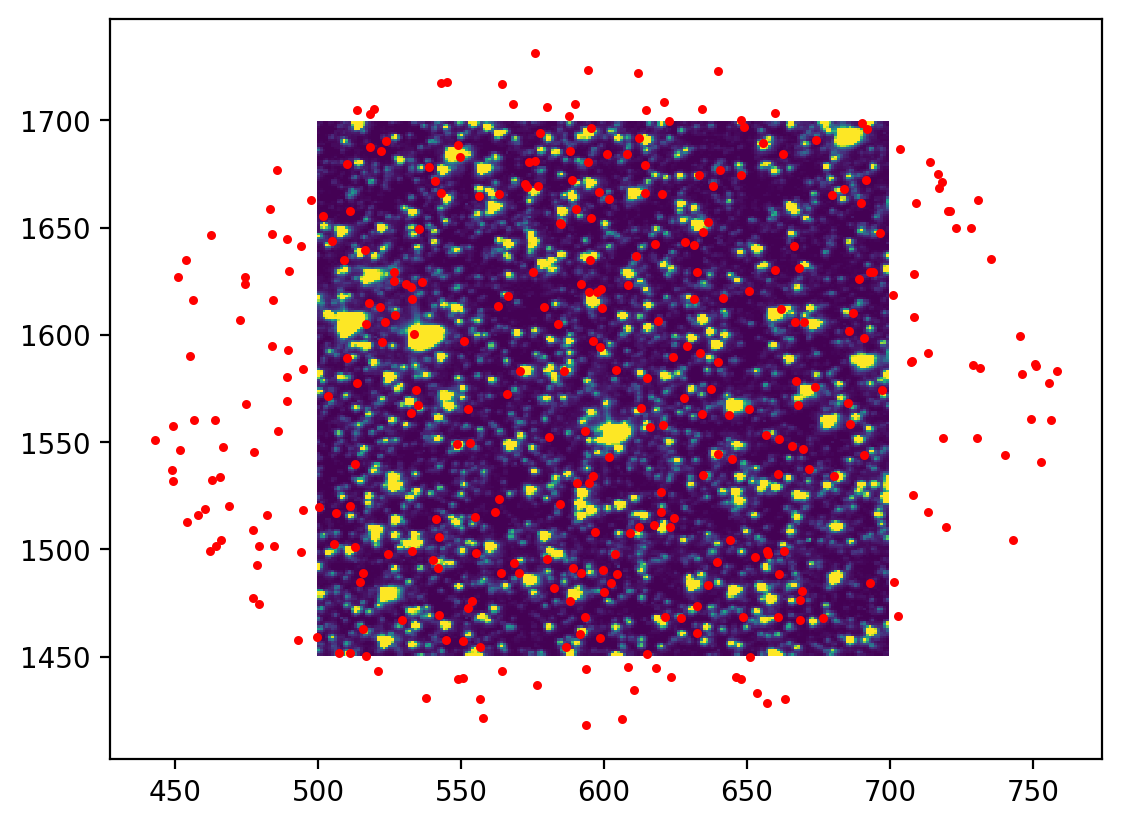

In [455]:
# plt.imshow(sf.data, vmin=0, vmax=200)
R, C = np.mgrid[cutout[0][0]:cutout[0][1], cutout[1][0]:cutout[1][1]]
plt.pcolormesh(R, C, sf.data, vmin=0, vmax=200)
bright_sources = df.phot_rp_mean_flux > 1e5

# corner_y = hdu1[1].header['CRPIX2'] - hdu1[1].header['NAXIS2']/2
# corner_x = hdu1[1].header['CRPIX1'] - hdu1[1].header['NAXIS1']/2

# plt.scatter(df["X0"][bright_sources] - corner_x, df["Y0"][bright_sources] - corner_y, s=5, c="r")
plt.scatter(df["X0"][bright_sources], df["Y0"][bright_sources], s=5, c="r")


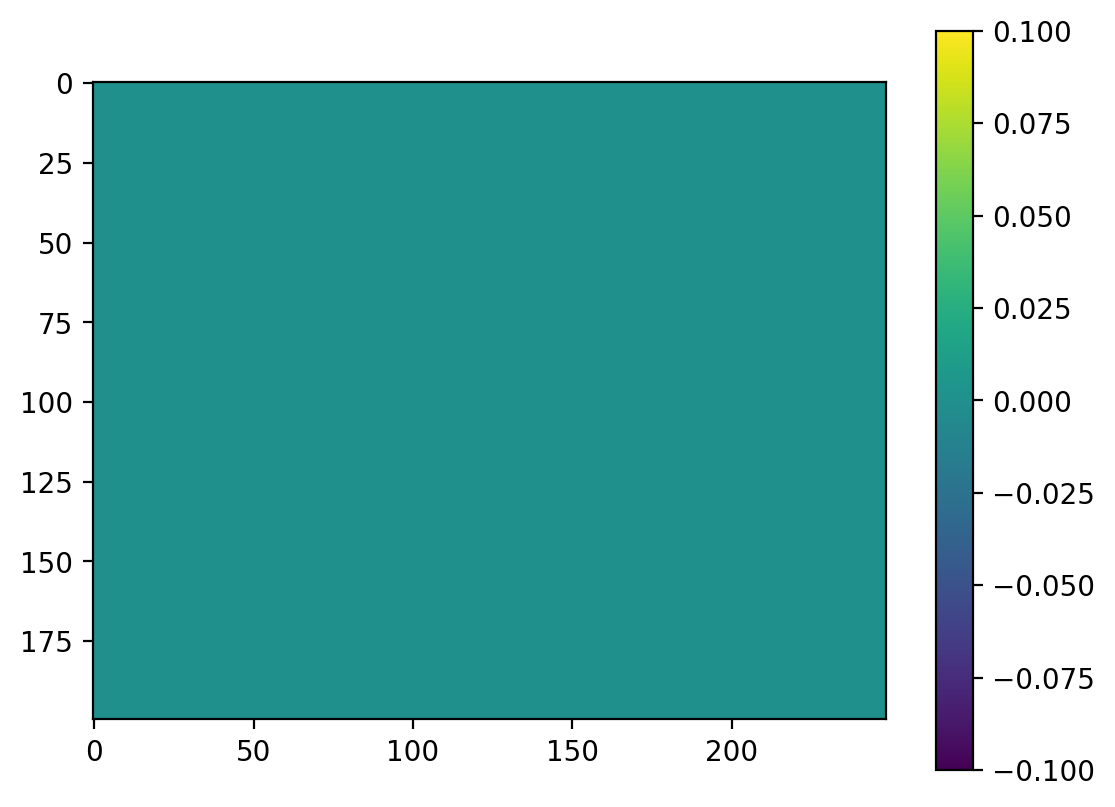

In [ ]:
# s, ds_x, ds_y = sf._get_gaussian_scene(std=1.2)
s = sf.OLD_get_gaussian_scene(std=2)

plt.imshow(s.sum(axis=1).reshape(sf.shape))
# plt.imshow(sf.y.reshape(sf.shape), vmax=200)
plt.colorbar()


# image = sparse.hstack([s[:,:-2].sum(axis=1), s[:,-2], s[:,-1]], 'csr')
# image = sparse.hstack(s).sum(axis=1)
# sf._get_gaussian_design_matrix()
# image.shape
# s.shape

# Cont